<h1 align="center"> INF6804 Lab 1: Lucas Kanade Optical Flow </h1>
<br>
<h3 align="center"> Daniel Wang, Oumayma Messoussi </h3>
<br>

In [1]:
import cv2
import numpy as np
import glob
import argparse
import time, datetime
from matplotlib import pyplot as plt
from collections import namedtuple
import random as rng

### OpenCV Lucas Kanade sparse optical flow test

In [ ]:
# Source: https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html (with modifications)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 50,
                       qualityLevel = 0.2,
                       minDistance = 2,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0, 255, (100, 3))

for video_path in glob.glob('.\CDNet\*.mp4'):

    print('Processing ' + video_path + ' ..')
    cap = cv2.VideoCapture(video_path)
    
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    
    kp_update = 0
    
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    
    it = 0
    total_time = datetime.timedelta(seconds=0)
    
    while(1):
        ret, frame = cap.read()
        
        kp_update += 1
        if ret is True:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            continue
        
        # calculate optical flow and run time
        prev_time = time.time()
        
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        
        run_time = datetime.timedelta(seconds=time.time() - prev_time)
        total_time += run_time
        it += 1
        
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        
        # draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
            frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
            
        img = cv2.add(frame, mask)
        cv2.imshow(video_path, img)
        
        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
        
        if kp_update == 10:
            p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
            kp_update = 0
        
    print('\tAverage run time for LK optical flow = ' + str(total_time/float(i)) + '\n')
    
cap.release()
cv2.destroyAllWindows()

<br>

### Farneback dense optical flow test

Processing ./CDNet\Bad_Weather ..
	in001023.jpg
	in001024.jpg


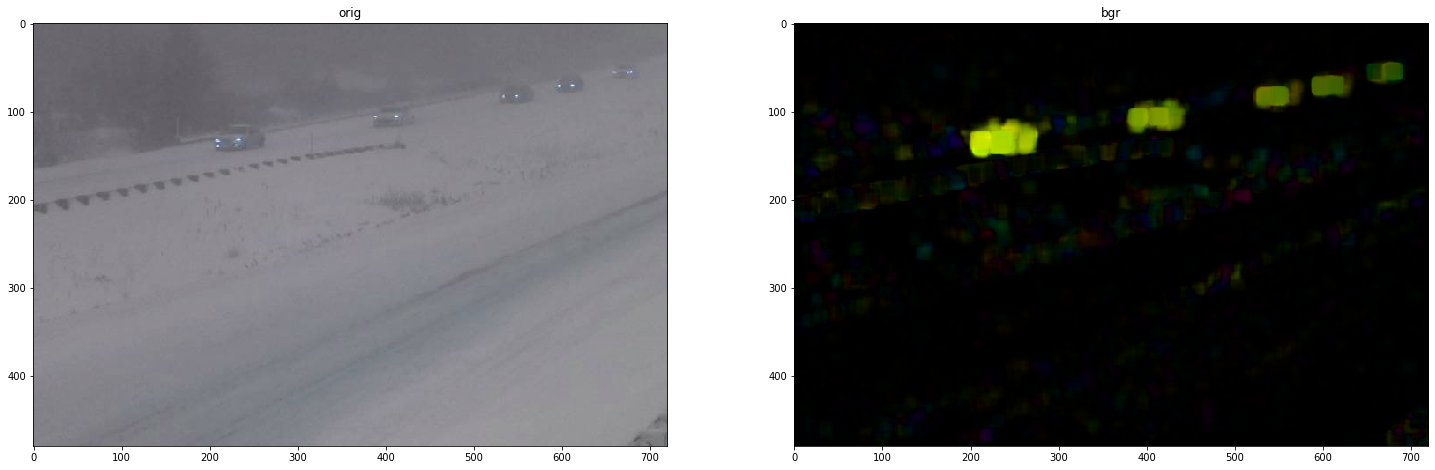

	in001025.jpg


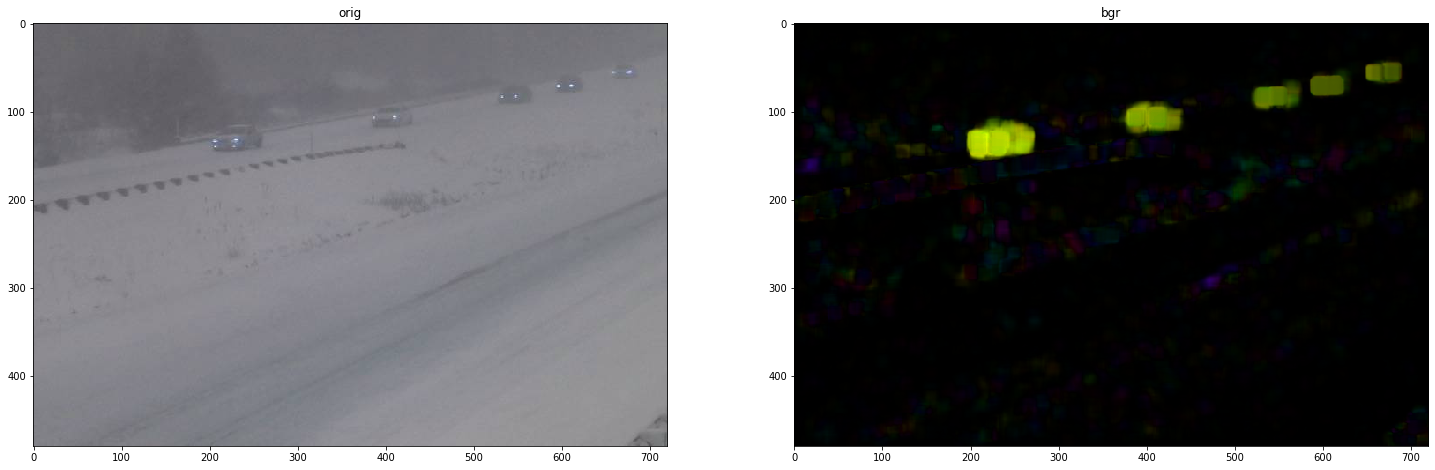

	in001026.jpg


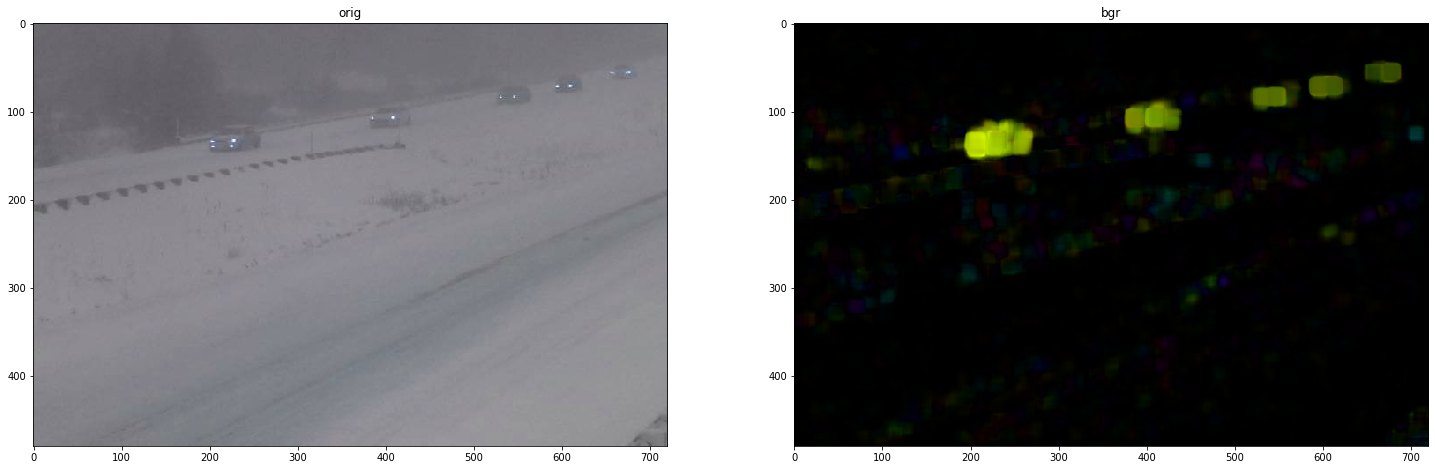

	in001027.jpg


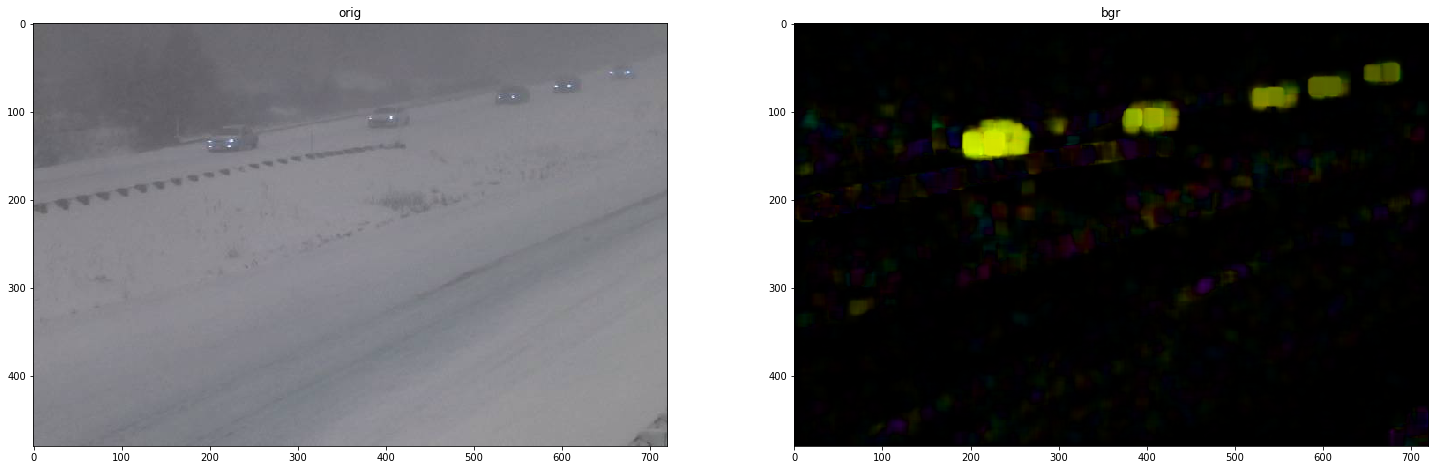

	in001028.jpg


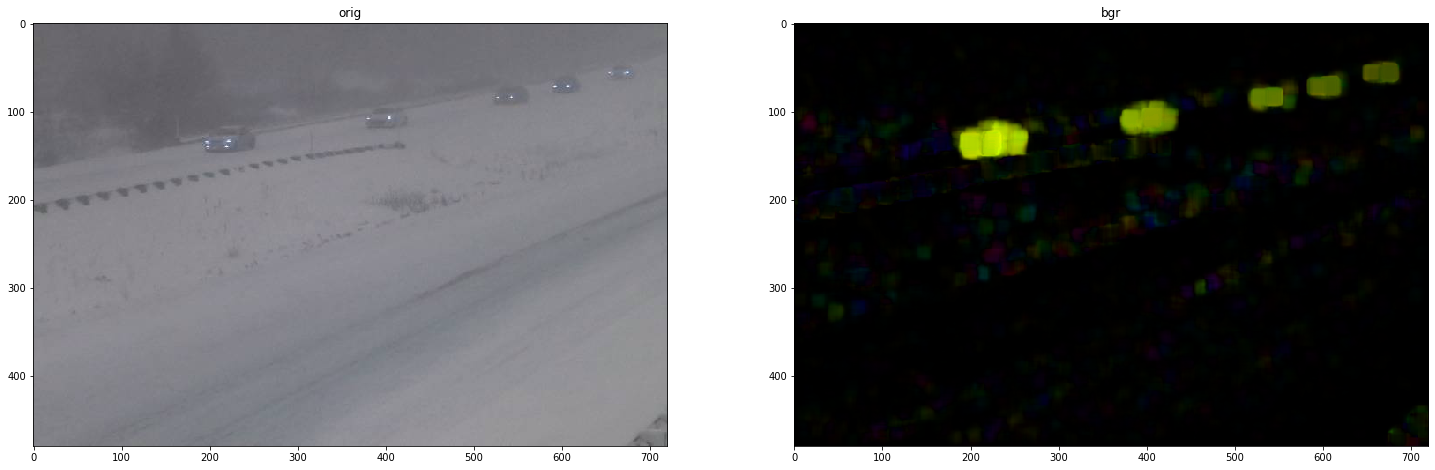

	Average run time for Farneback optical flow = 0:00:00.042388

Processing ./CDNet\Baseline ..
	in000417.jpg
	in000418.jpg


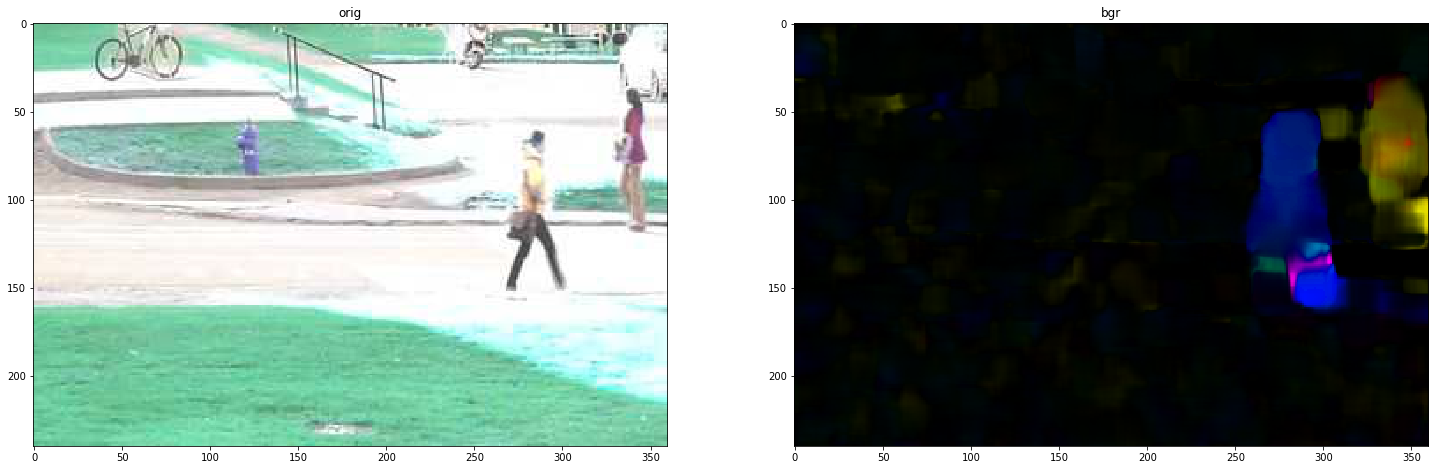

	in000419.jpg


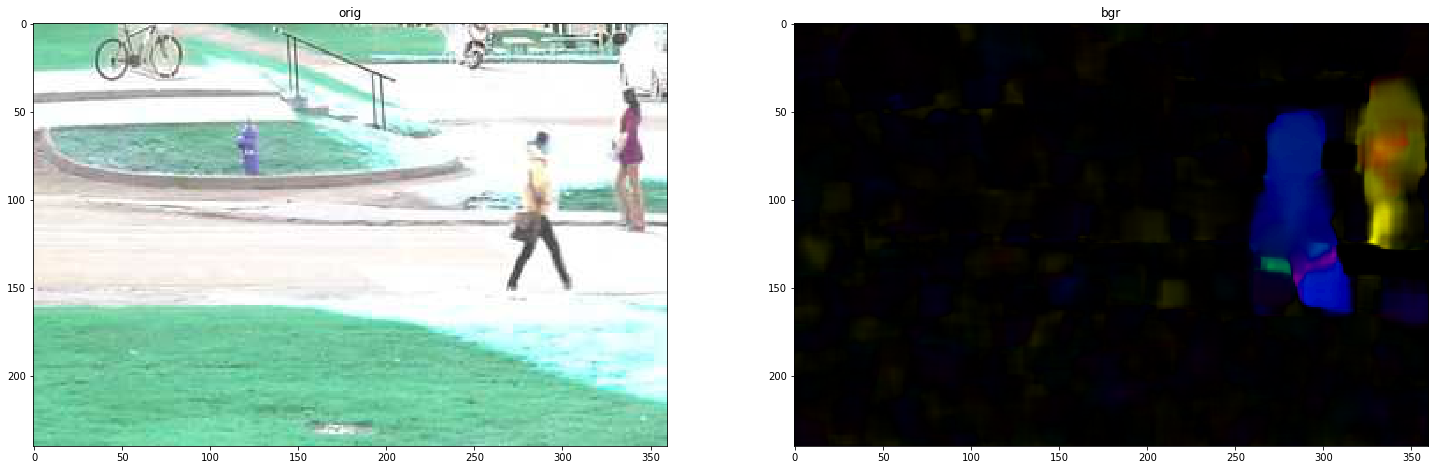

	in000420.jpg


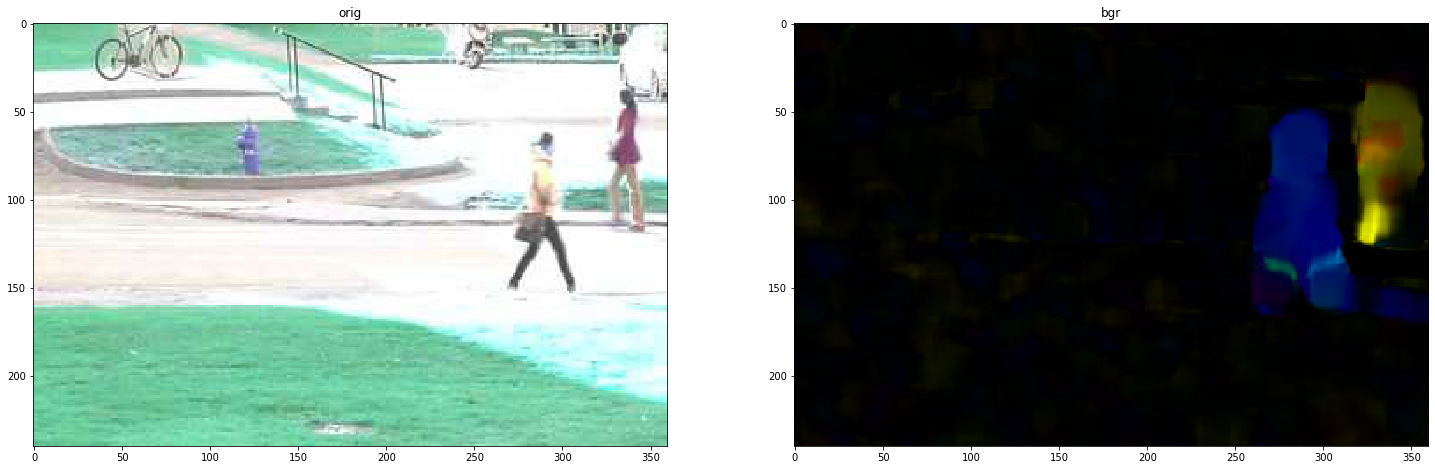

	in000421.jpg


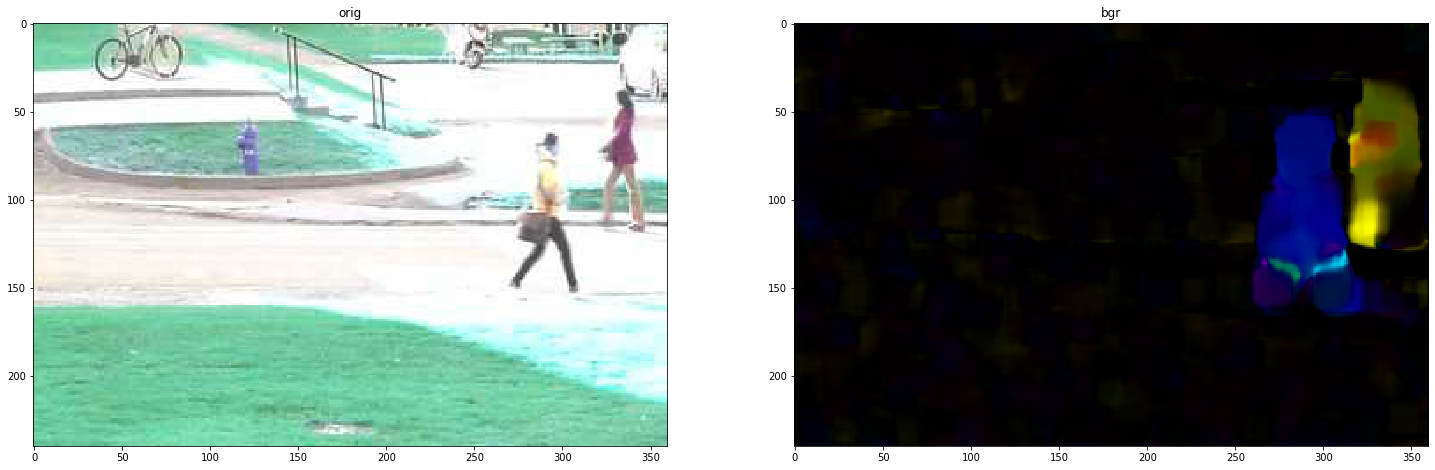

	in000422.jpg


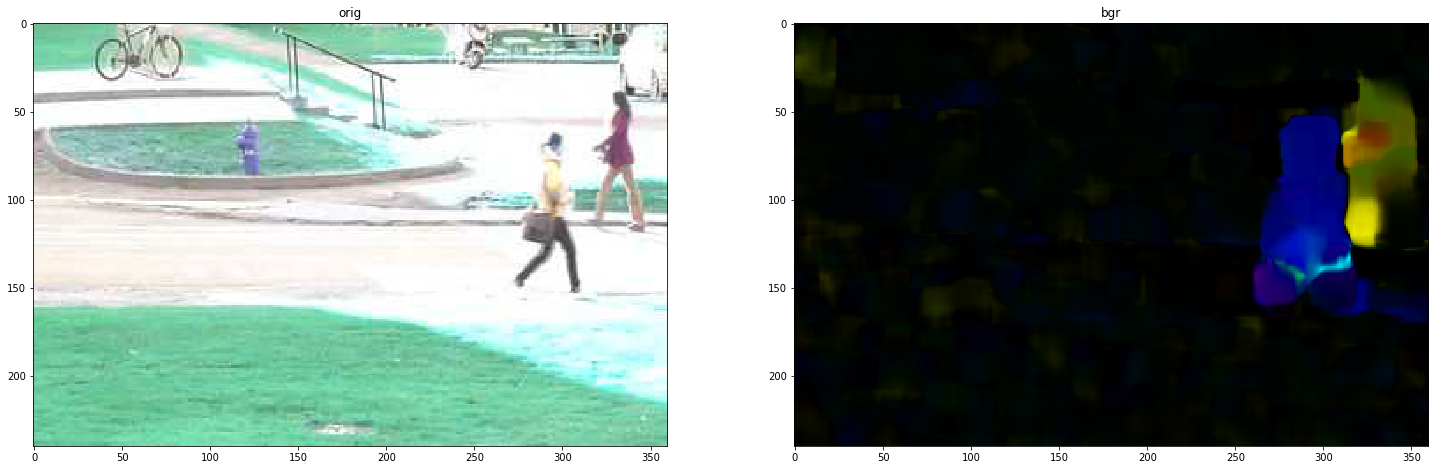

	Average run time for Farneback optical flow = 0:00:00.011547

Processing ./CDNet\Night_Videos ..
	in000004.jpg
	in000005.jpg


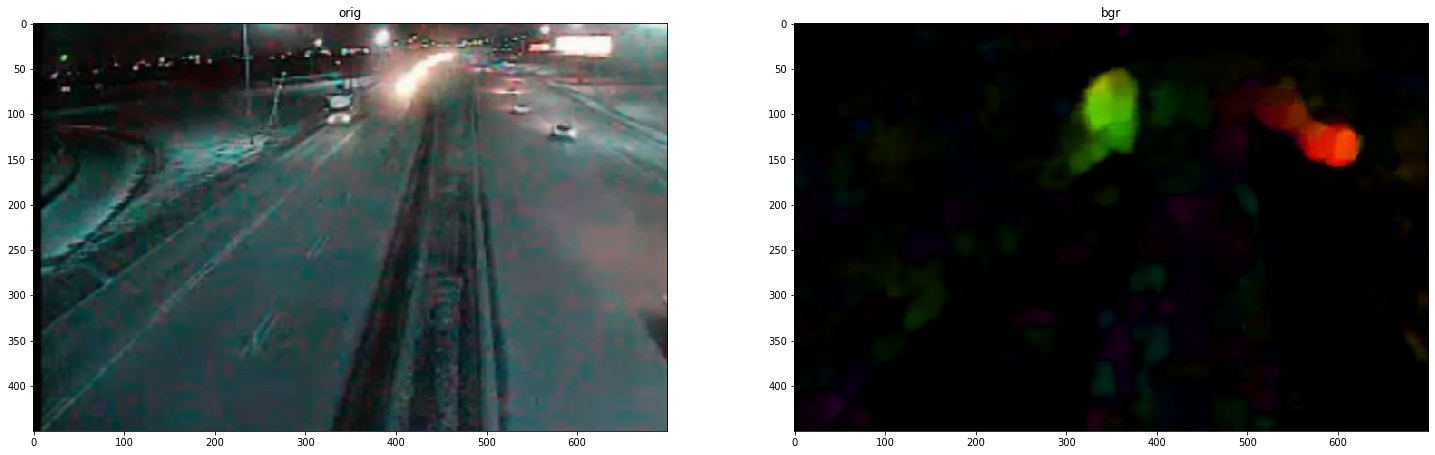

	in000008.jpg


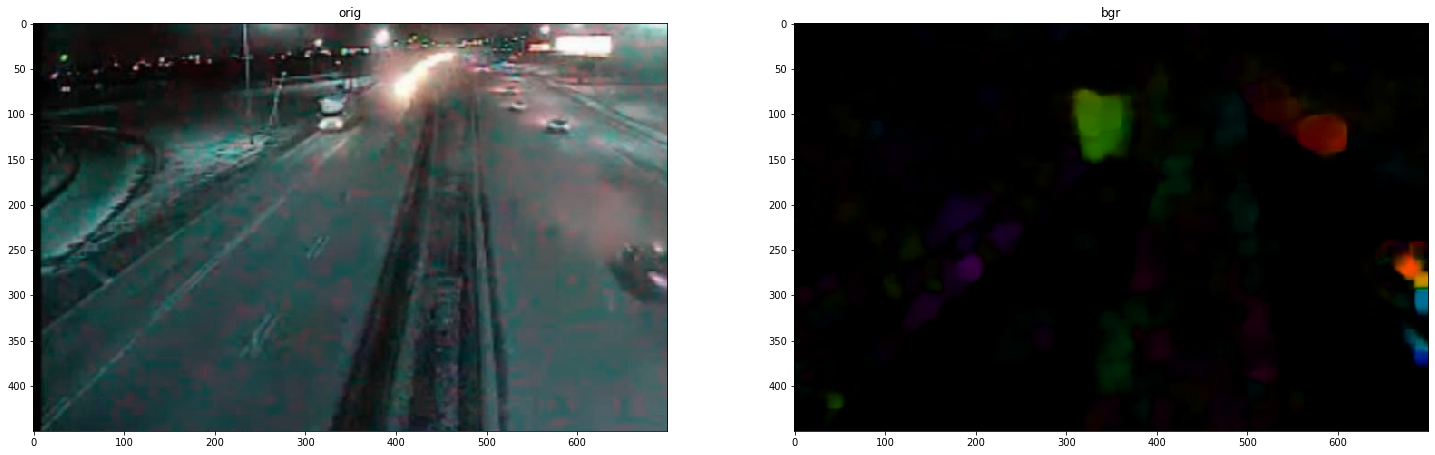

	in000011.jpg


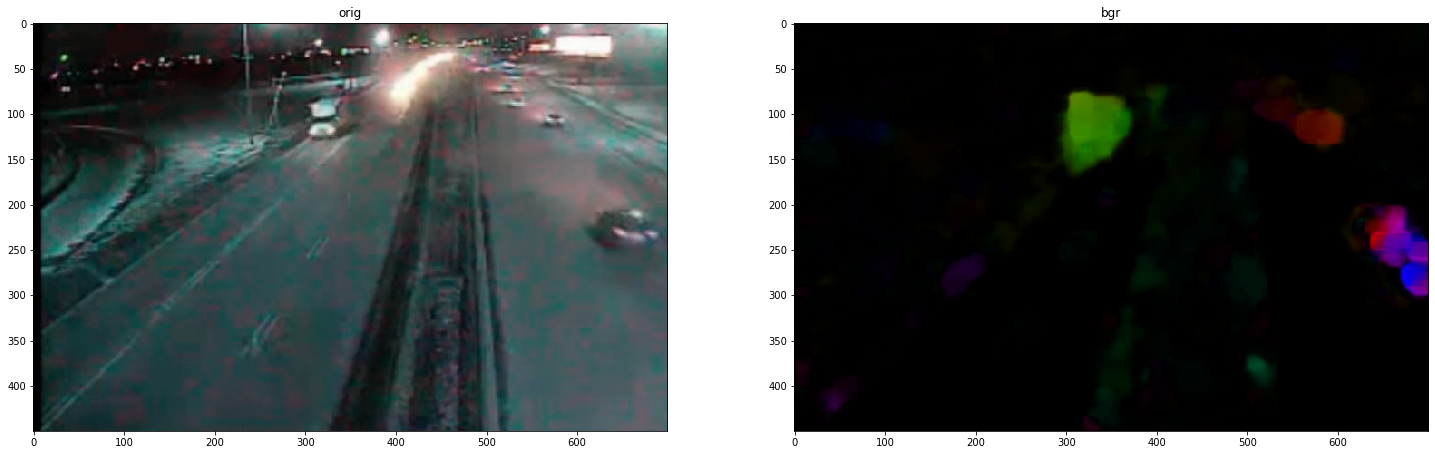

	in000012.jpg


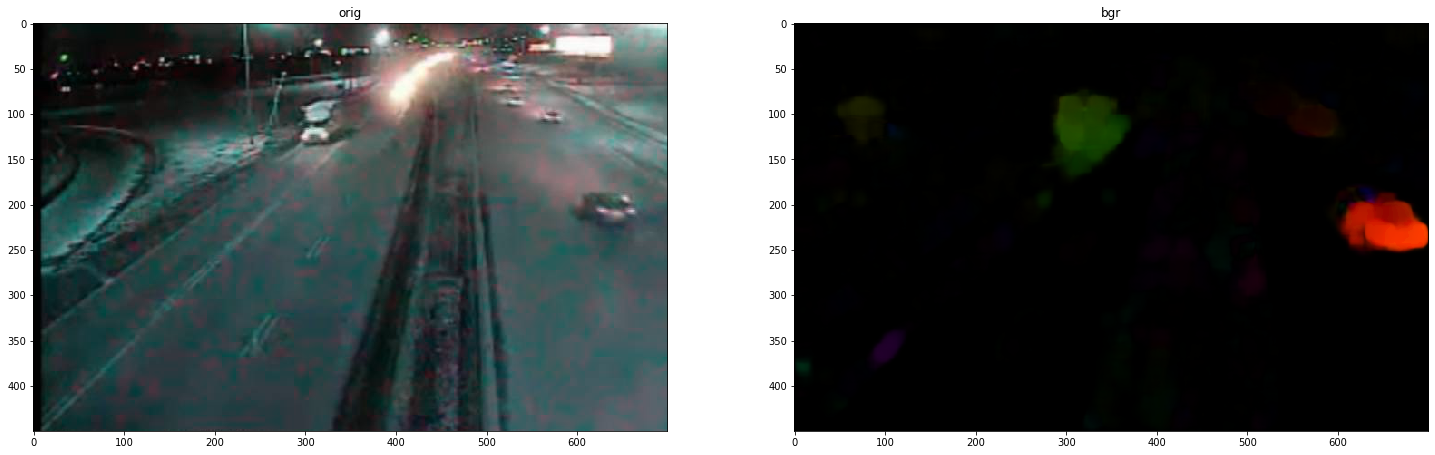

	in000015.jpg


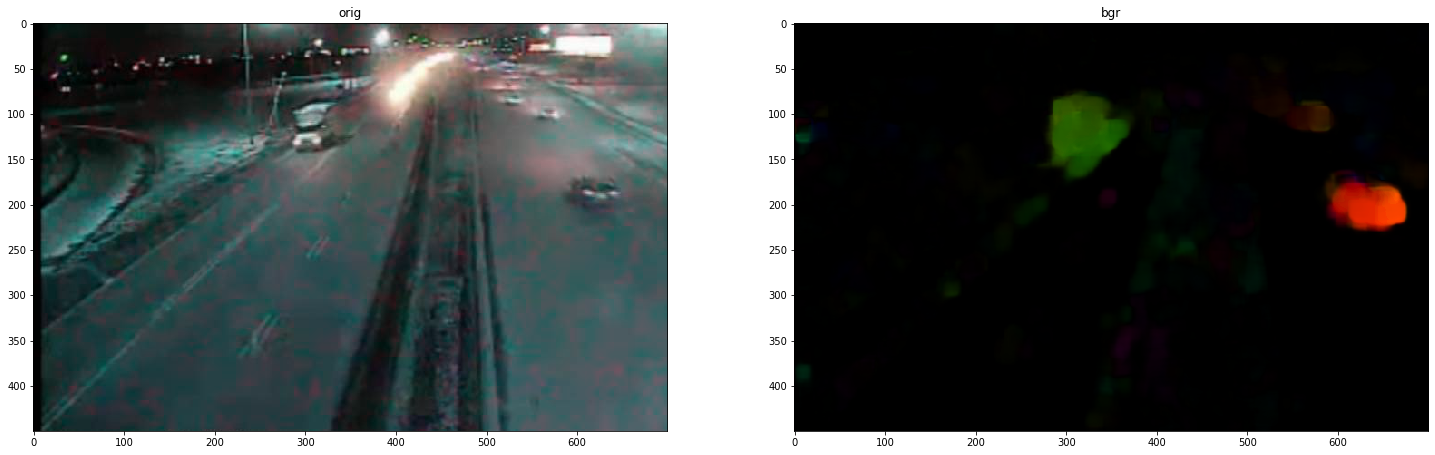

	Average run time for Farneback optical flow = 0:00:00.037655



In [7]:
# Source: https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html (with modifications)

Baseline = ['in000417.jpg', 'in000418.jpg', 'in000419.jpg', 'in000420.jpg', 'in000421.jpg', 'in000422.jpg']
Bad_Weather = ['in001023.jpg', 'in001024.jpg', 'in001025.jpg', 'in001026.jpg', 'in001027.jpg', 'in001028.jpg']
Night_videos = ['in000004.jpg', 'in000005.jpg', 'in000008.jpg', 'in000011.jpg', 'in000012.jpg', 'in000015.jpg']

for subset in glob.glob('./CDNet/*'):

    print('Processing ' + subset + ' ..')
    
    it = 0
    
    if 'Baseline' in subset:
        search_list = Baseline
        bname = './CDNet/Baseline/pedestrians/input/'
        bname_gt = './CDNet/Baseline/pedestrians/groundtruth/'
        
    elif 'Bad_Weather' in subset:
        search_list = Bad_Weather
        bname = './CDNet/Bad_Weather/blizzard/input/'
        bname_gt = './CDNet/Bad_Weather/blizzard/groundtruth/'
        
    else:
        search_list = Night_videos
        bname = './CDNet/Night_Videos/fluidHighway/input/'
        bname_gt = './CDNet/Night_Videos/fluidHighway/groundtruth/'
    
    for img in search_list:
        print('\t'+img)
    
        if it == 0:
            old_frame = cv2.imread(bname+img)

            old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

            hsv = np.zeros_like(old_frame)
            hsv[...,1] = 255

            it += 1
            total_time = datetime.timedelta(seconds=0)

        else:
            
            frame = cv2.imread(bname+img)

            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # calculate optical flow and run time
            prev_time = time.time()

            flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

            run_time = datetime.timedelta(seconds=time.time() - prev_time)
            total_time += run_time

            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            
            fig = plt.figure(figsize=(25, 25))
            
            x = fig.add_subplot(1,2, 1)
            x.set_title('orig')
            plt.imshow(frame)
            
            y = fig.add_subplot(1,2, 2)
            y.set_title('bgr')
            plt.imshow(bgr)
            
            plt.show()

            k = cv2.waitKey(60) & 0xff
            if k == 27:
                break
            
            old_gray = frame_gray
            it += 1
        
    print('\tAverage run time for Farneback optical flow = ' + str(total_time/float(i)) + '\n')
    
cv2.destroyAllWindows()

<br>

### Evaluation: generate ground truth BBoxes and calculate IoU

In [2]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

Processing .\CDNet\Bad_Weather ..
Processing .\CDNet\Baseline ..
Processing .\CDNet\Night_Videos ..
0
1
	IOU evaluation ..


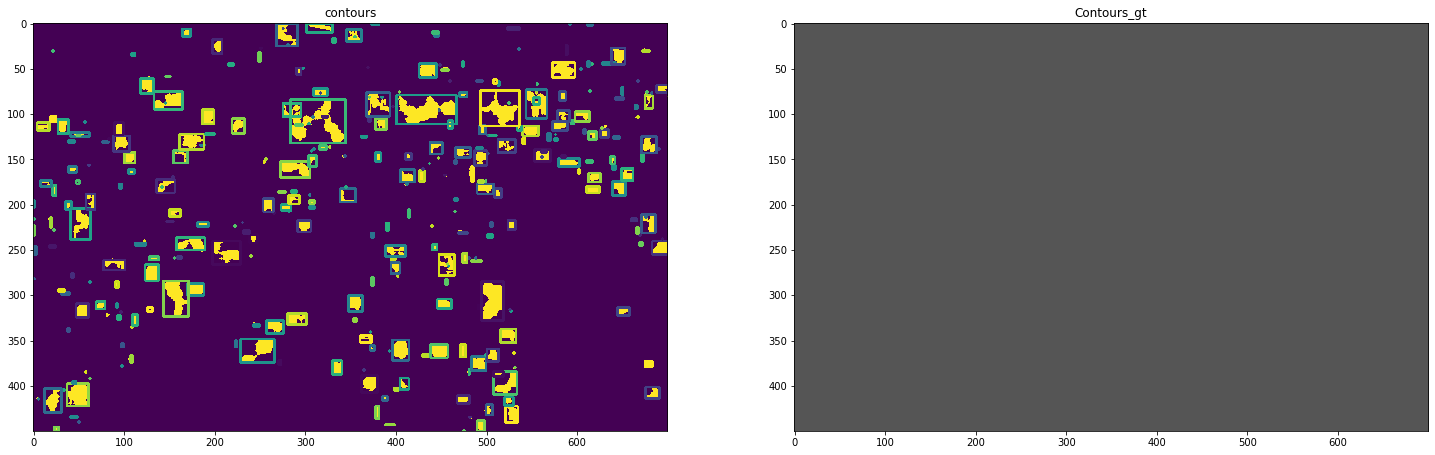

2
	IOU evaluation ..


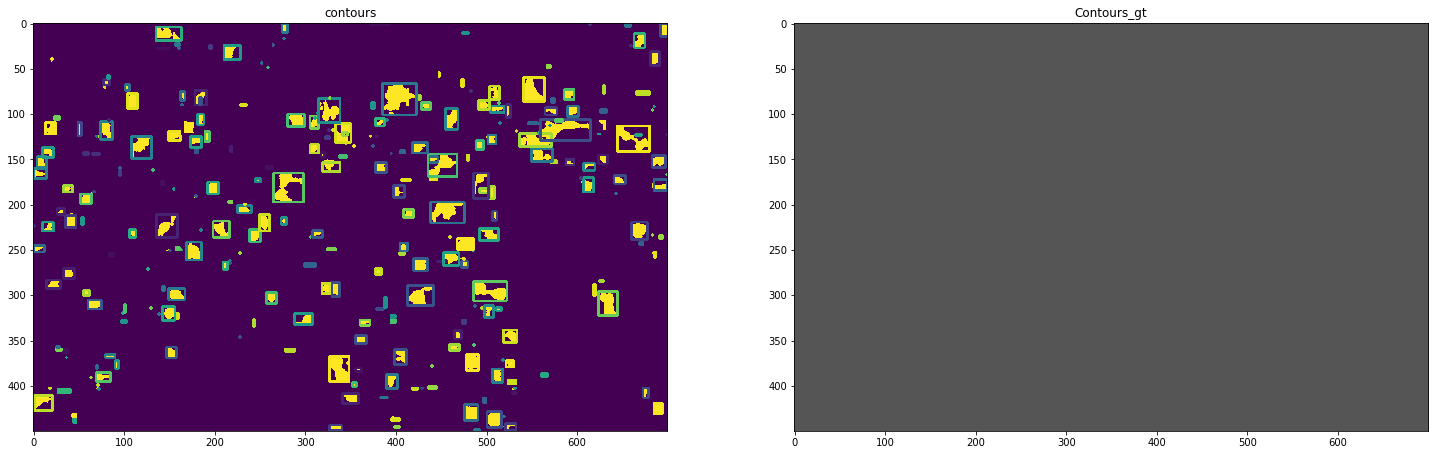

3
	IOU evaluation ..


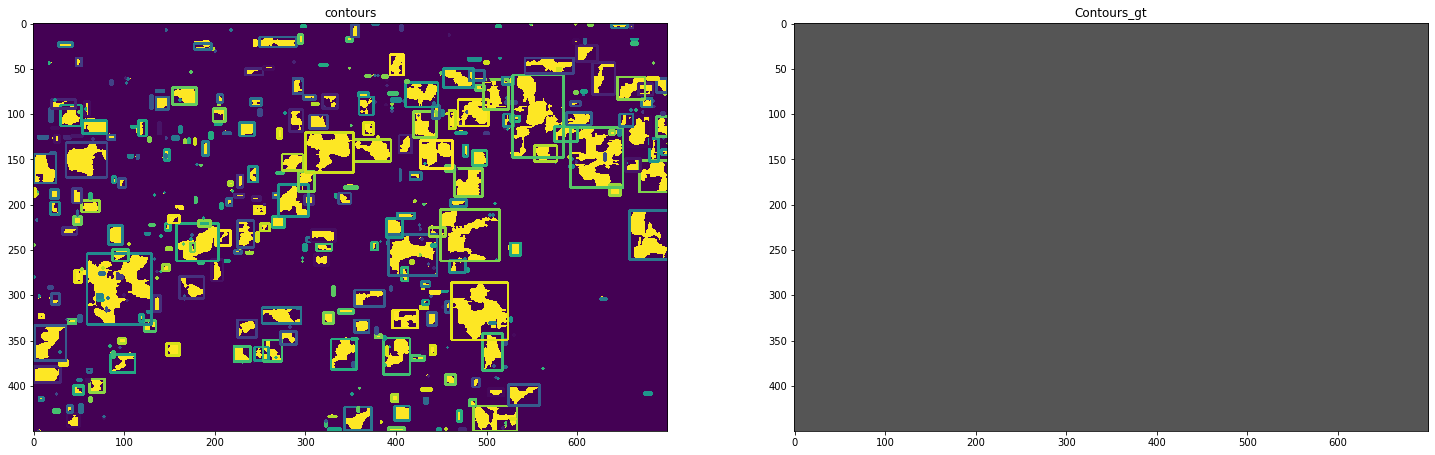

4
	IOU evaluation ..


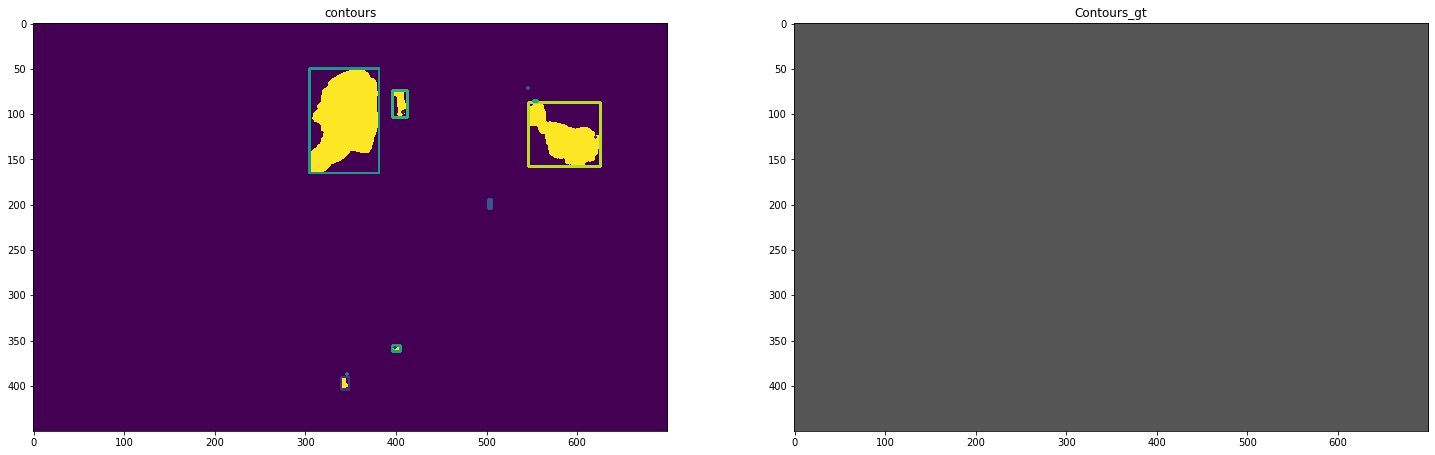

5
	IOU evaluation ..


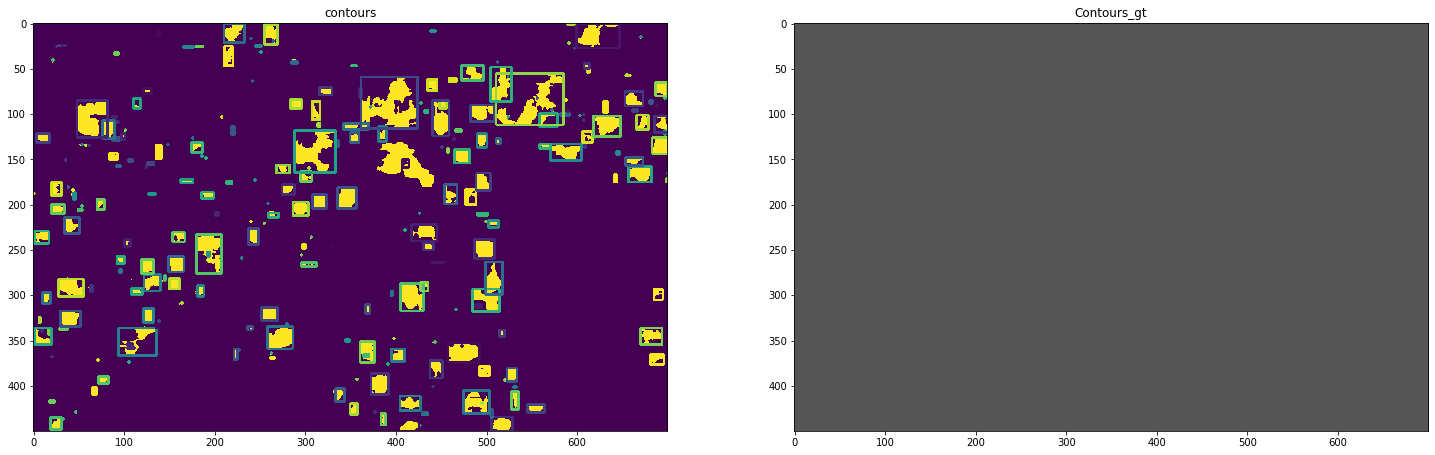

6
	IOU evaluation ..


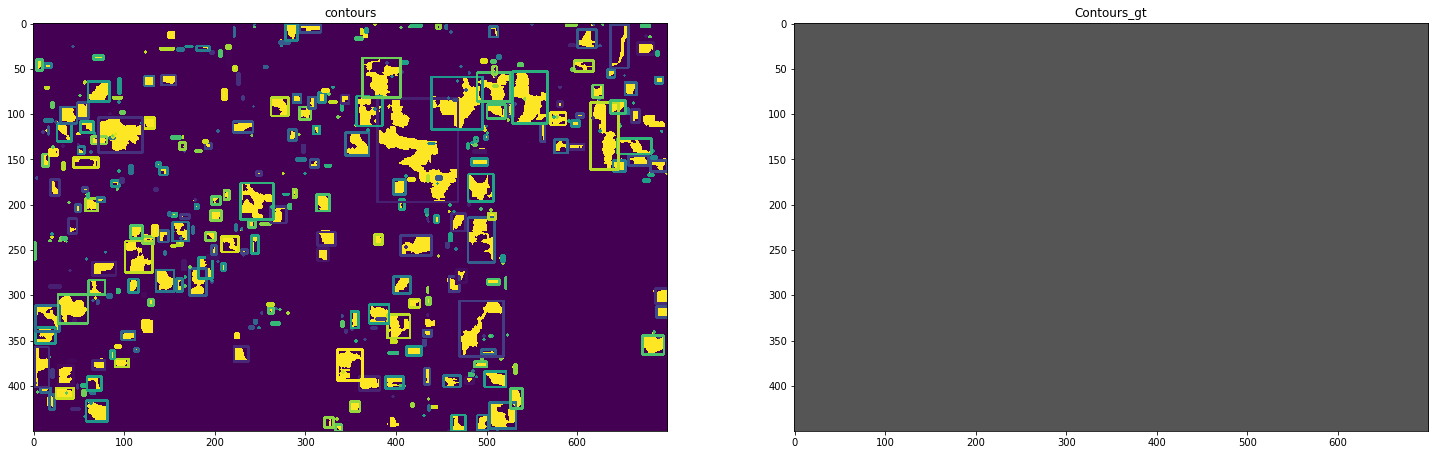

7
	IOU evaluation ..


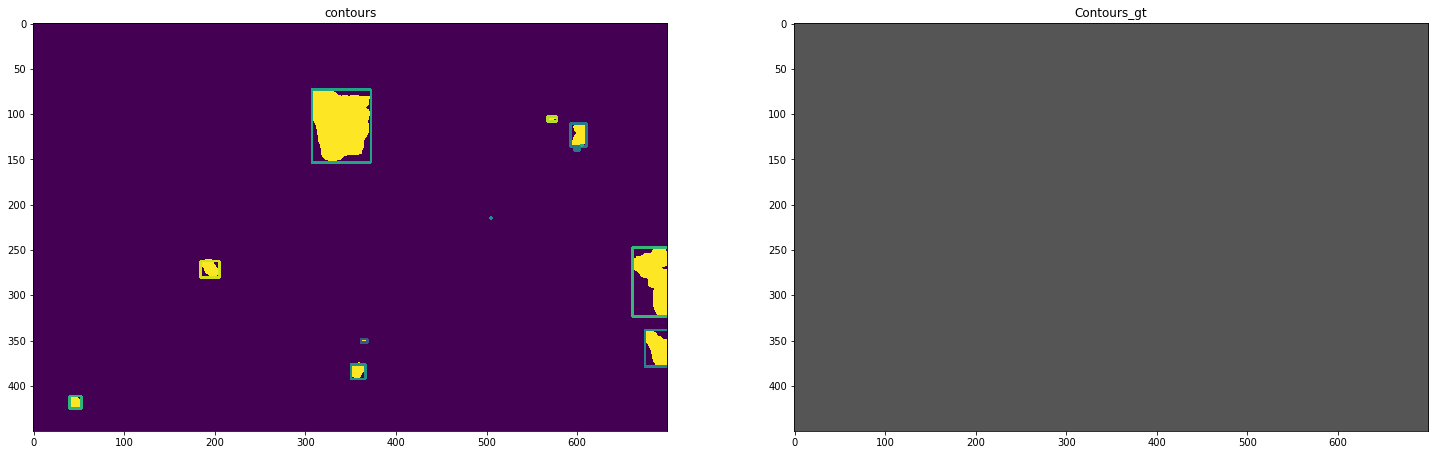

8
	IOU evaluation ..


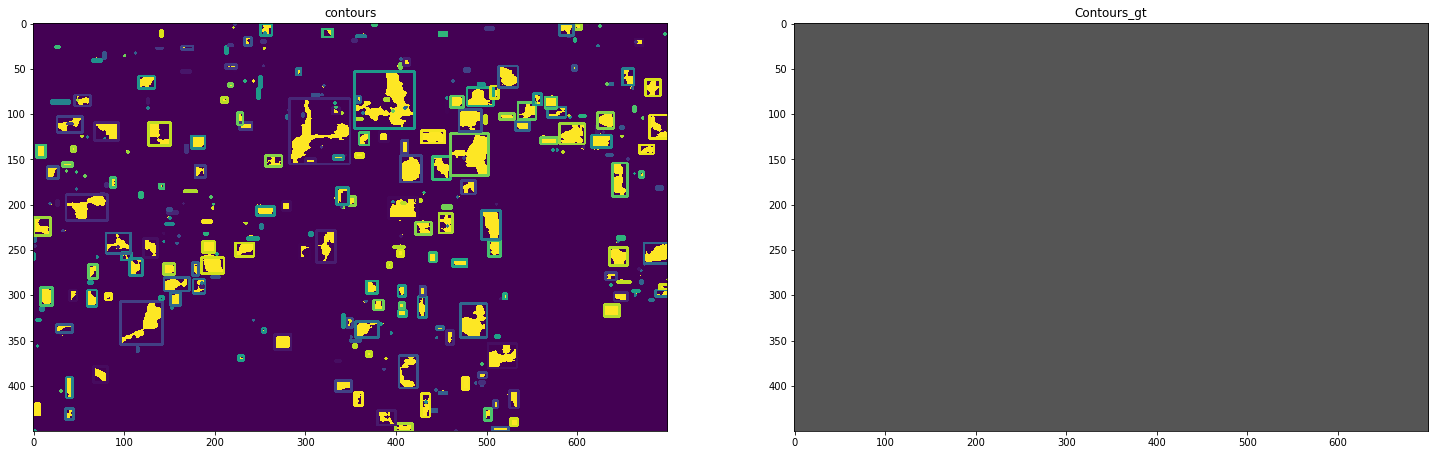

9
	IOU evaluation ..


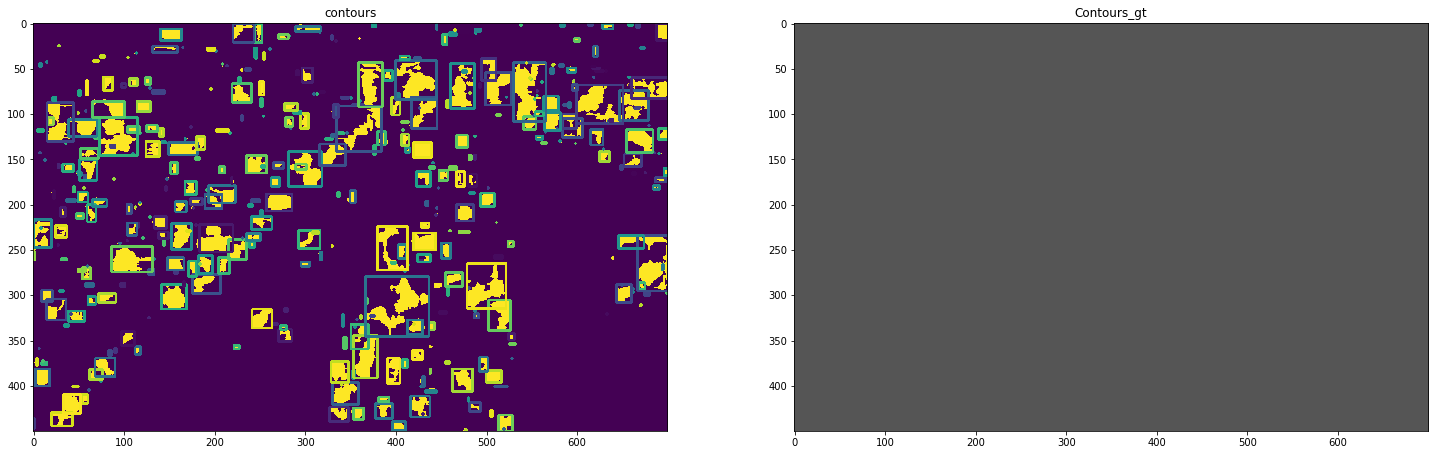

10
	IOU evaluation ..


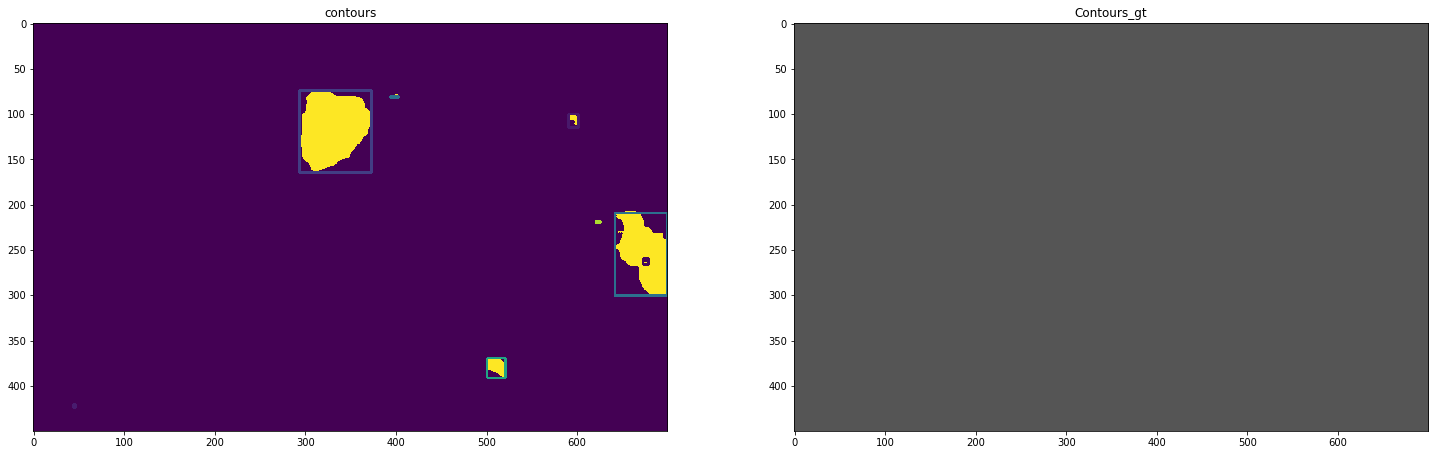

11
	IOU evaluation ..


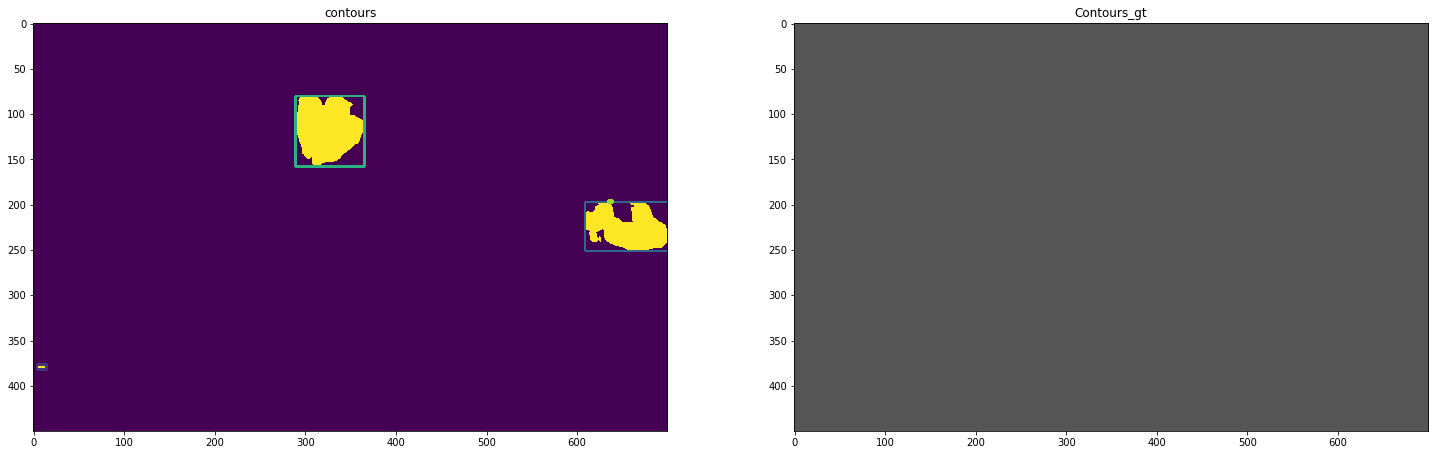

12
	IOU evaluation ..


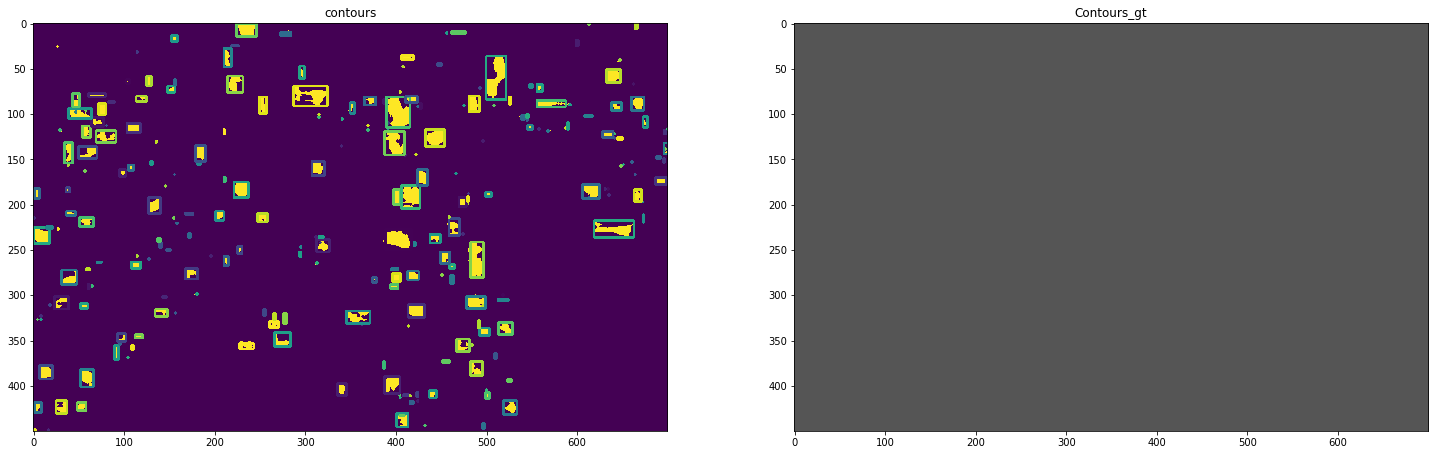

13
	IOU evaluation ..


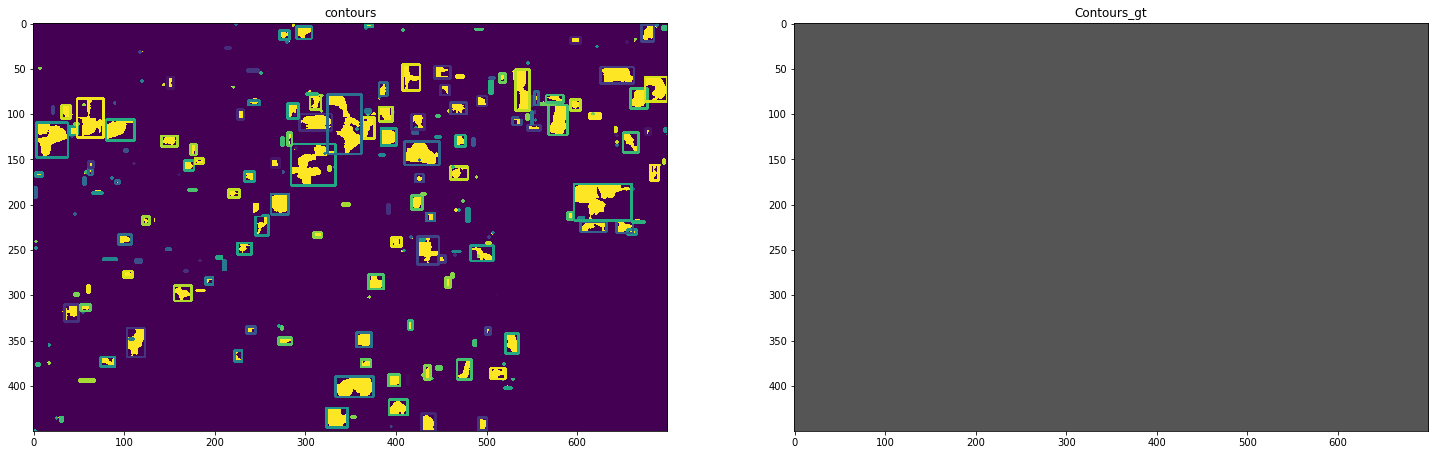

14
	IOU evaluation ..


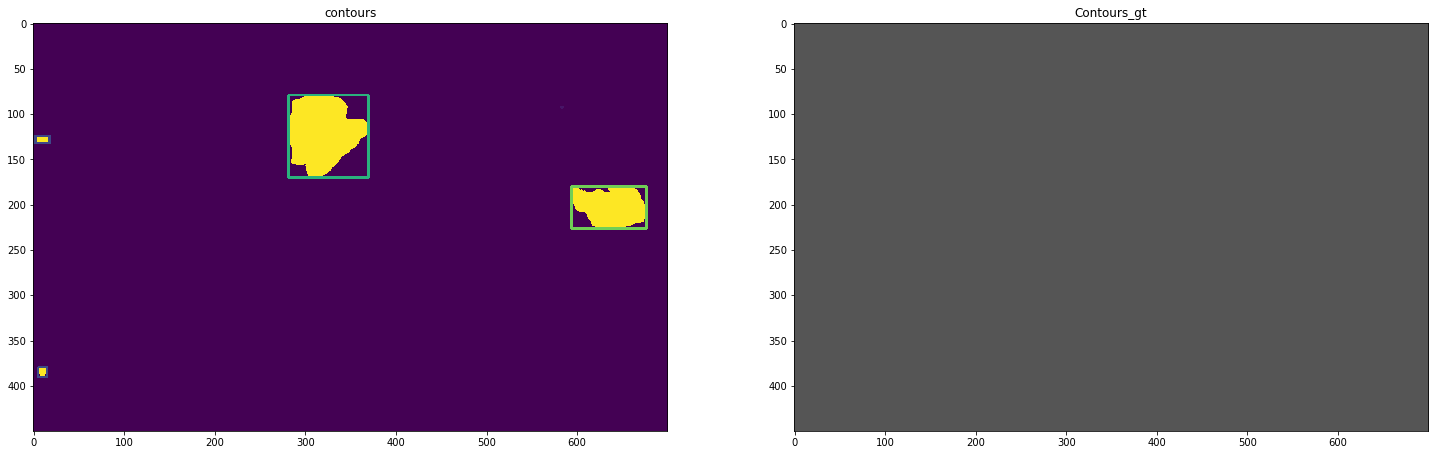

15
	IOU evaluation ..


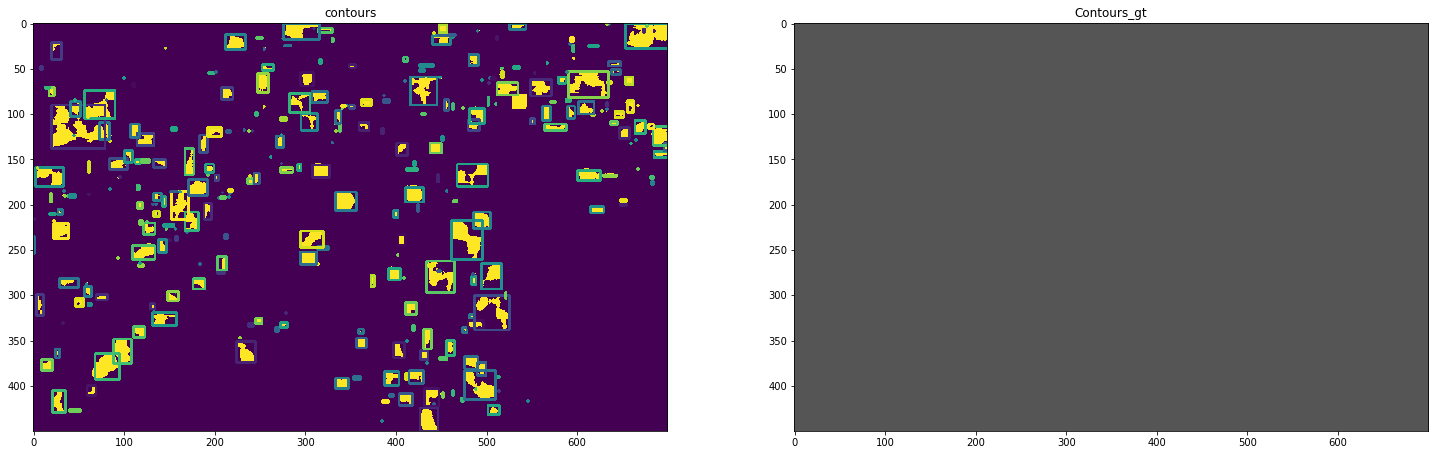

16
	IOU evaluation ..


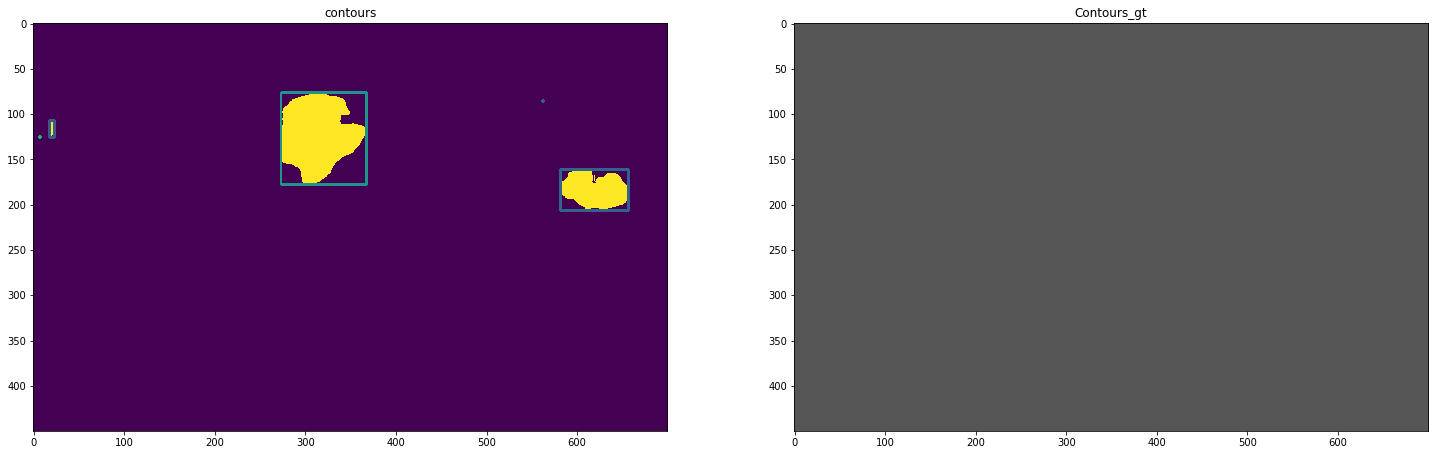

17
	IOU evaluation ..


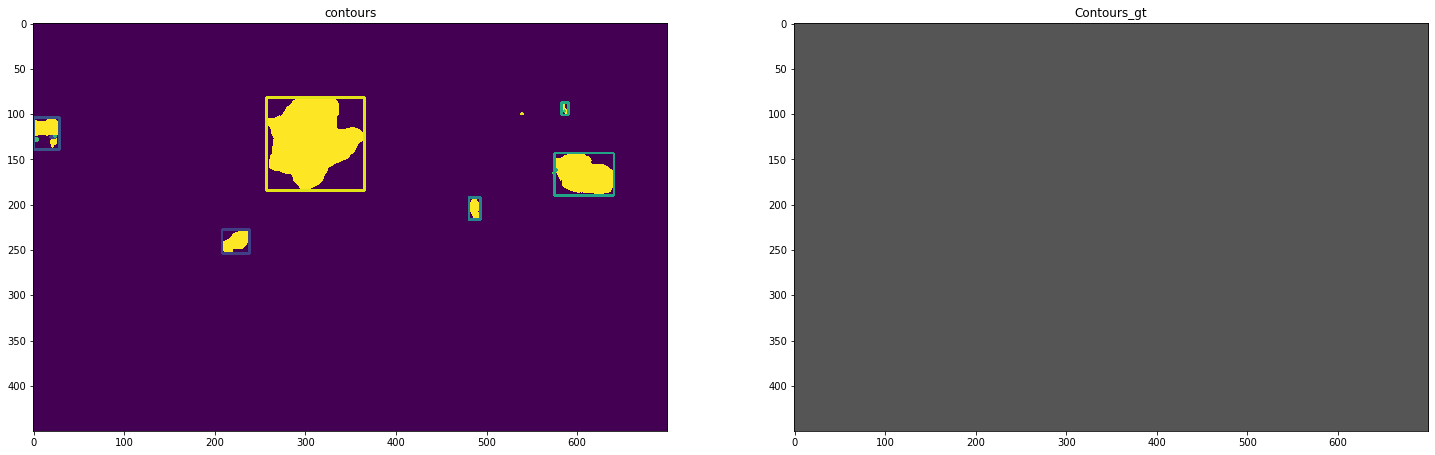

18
	IOU evaluation ..


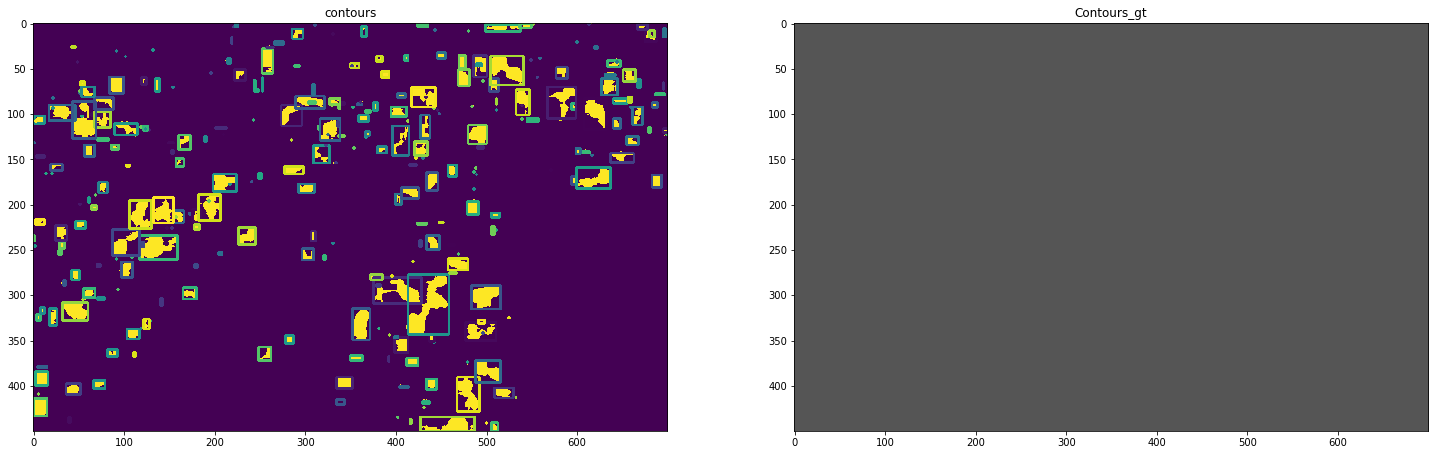

19
	IOU evaluation ..


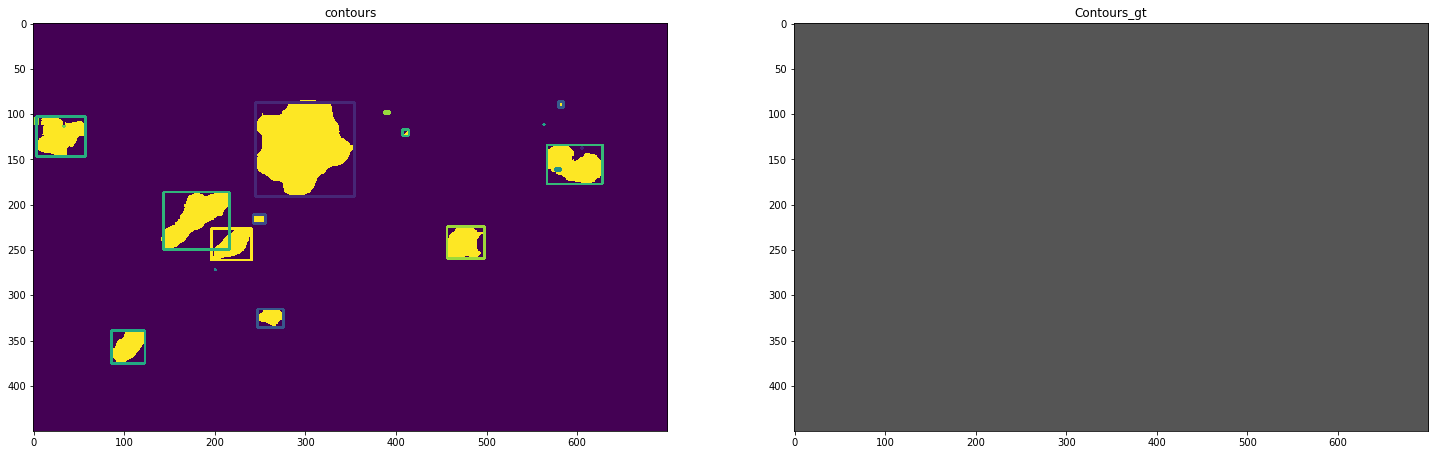

20
	IOU evaluation ..


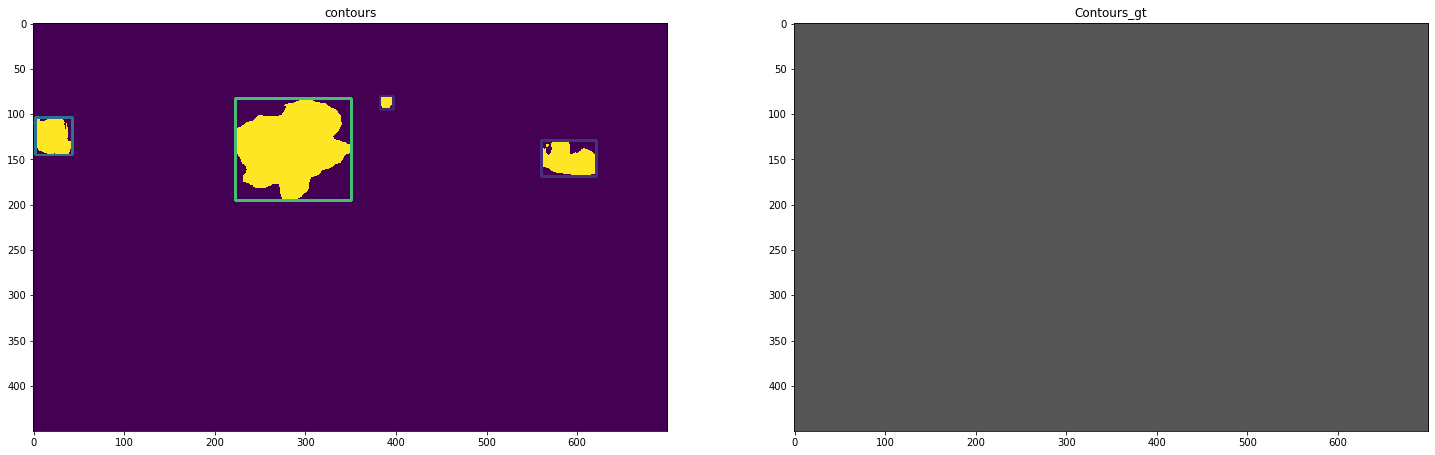

21
	IOU evaluation ..


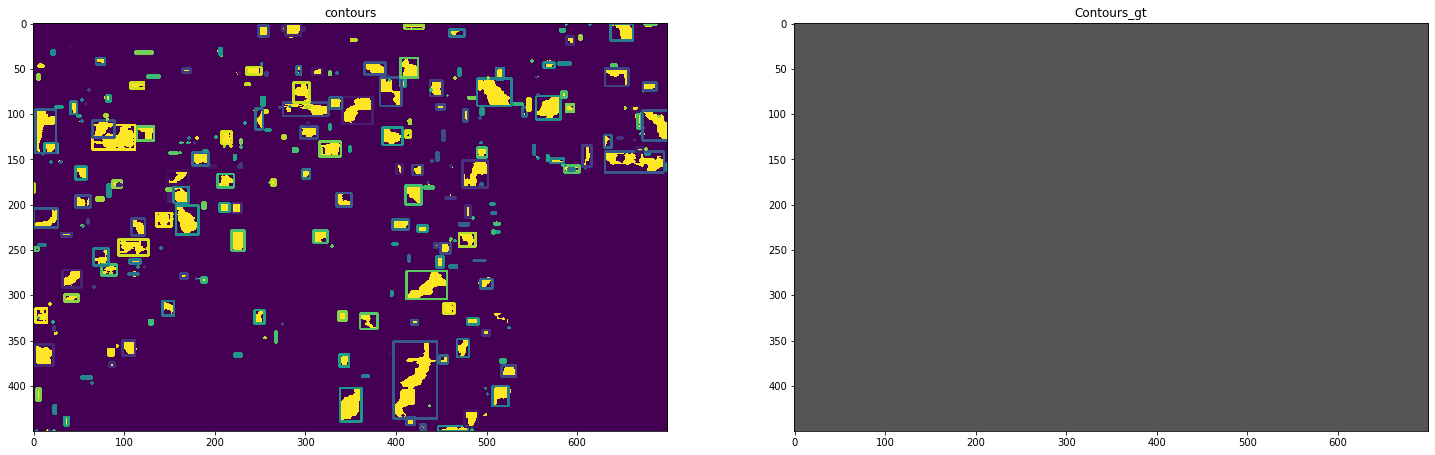

22
	IOU evaluation ..


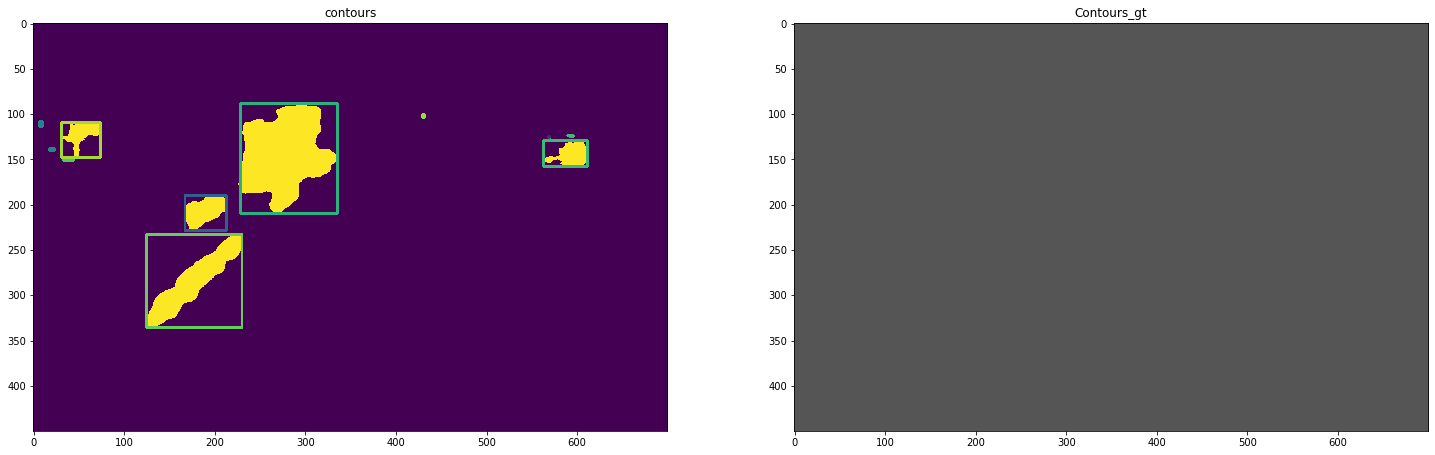

23
	IOU evaluation ..


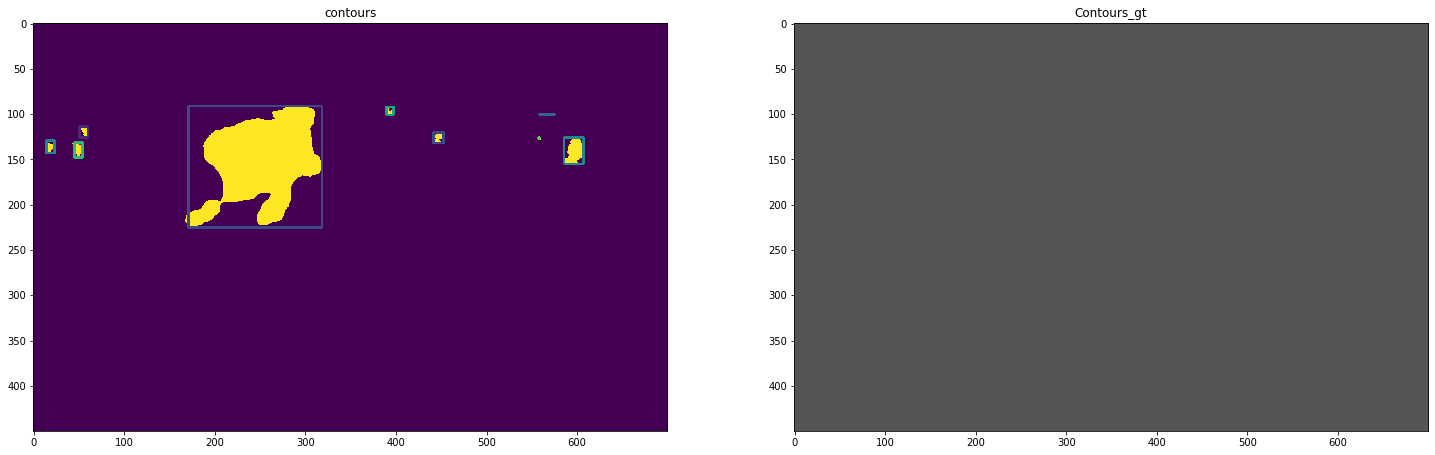

24
	IOU evaluation ..


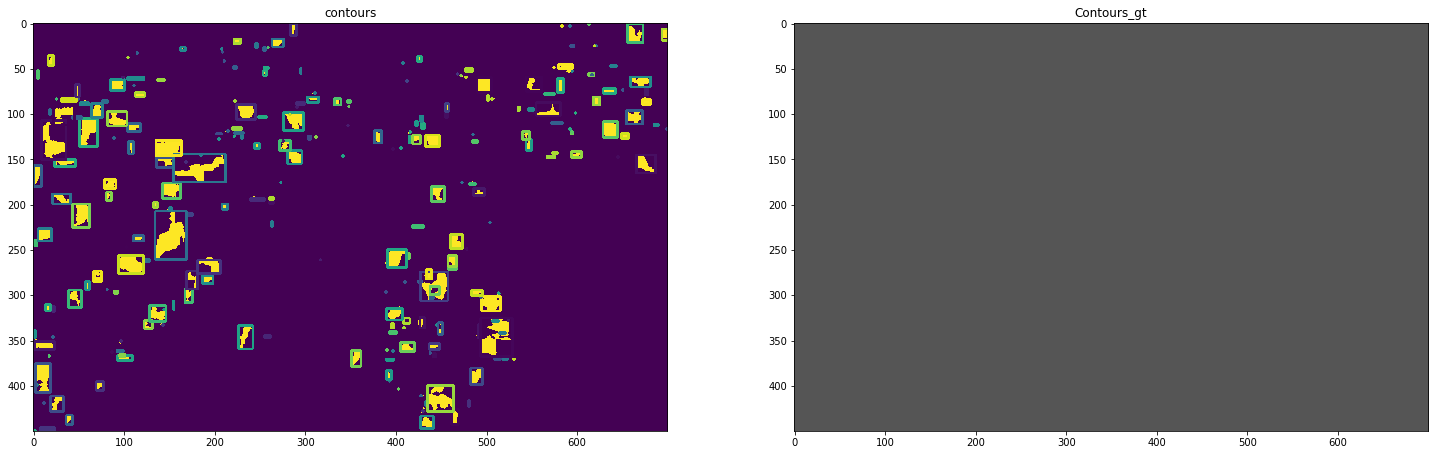

25
	IOU evaluation ..


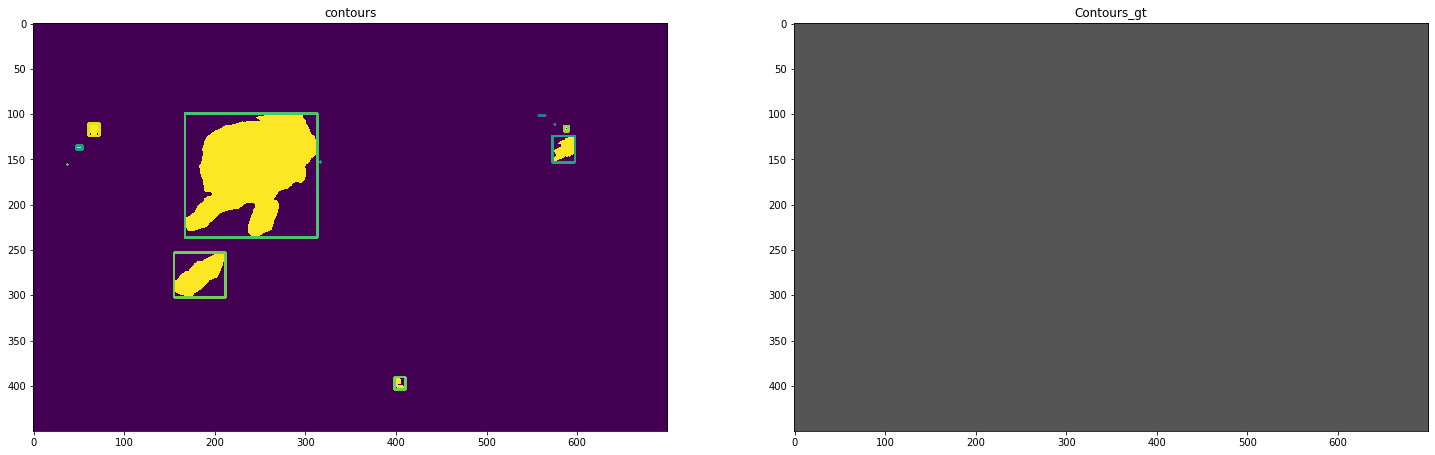

26
	IOU evaluation ..


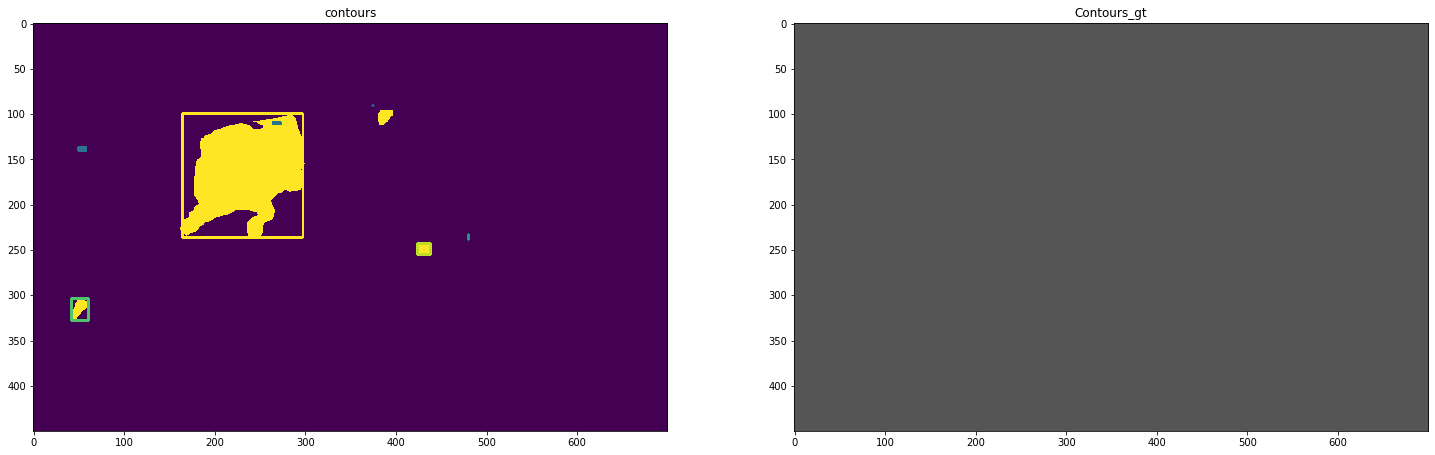

27
	IOU evaluation ..


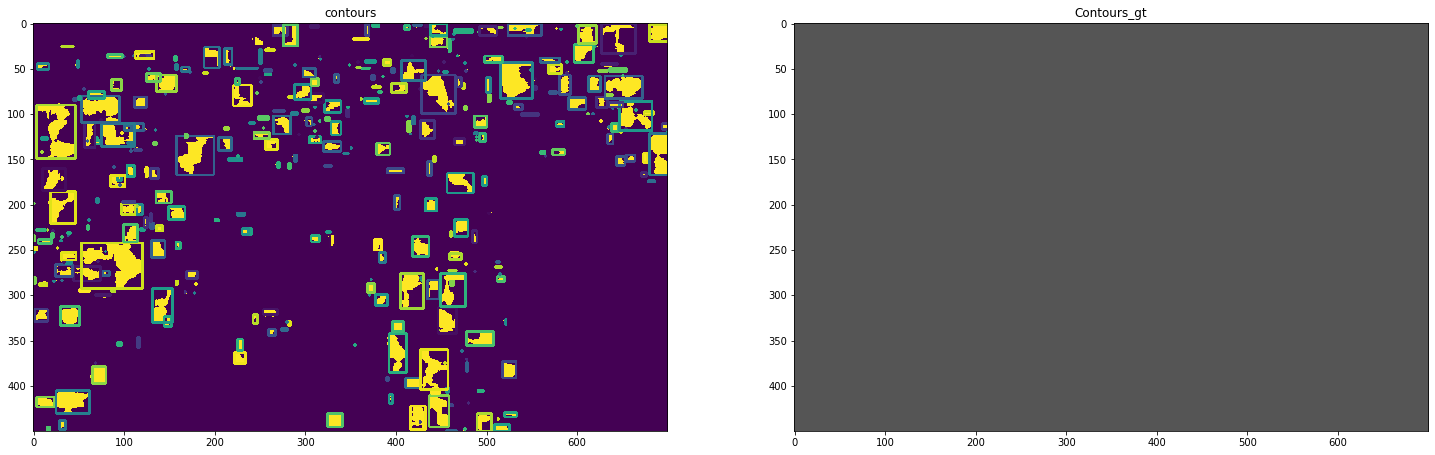

28
	IOU evaluation ..


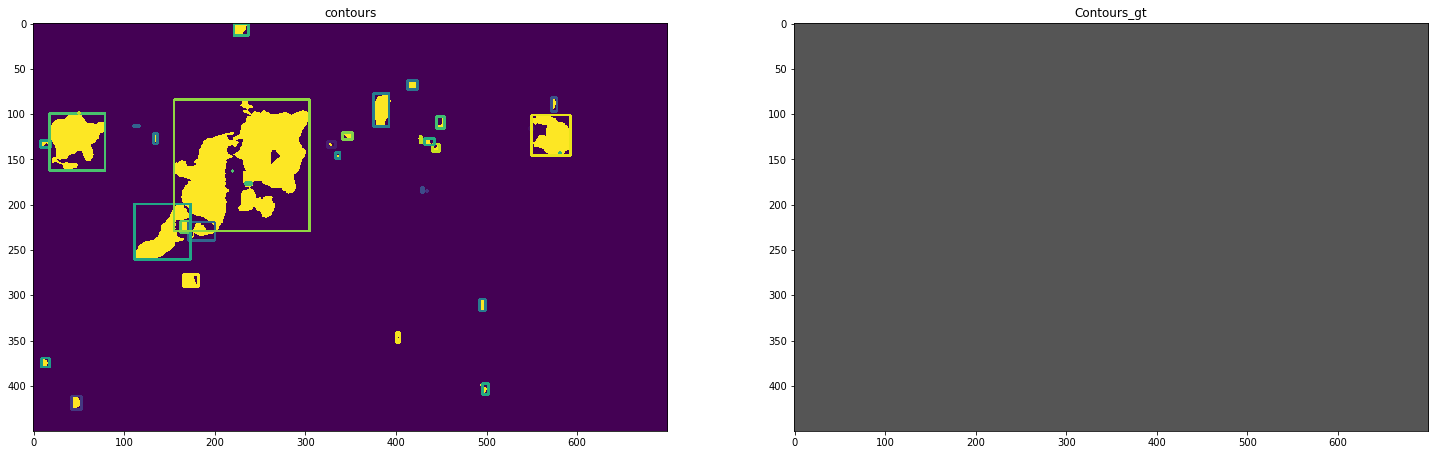

29
	IOU evaluation ..


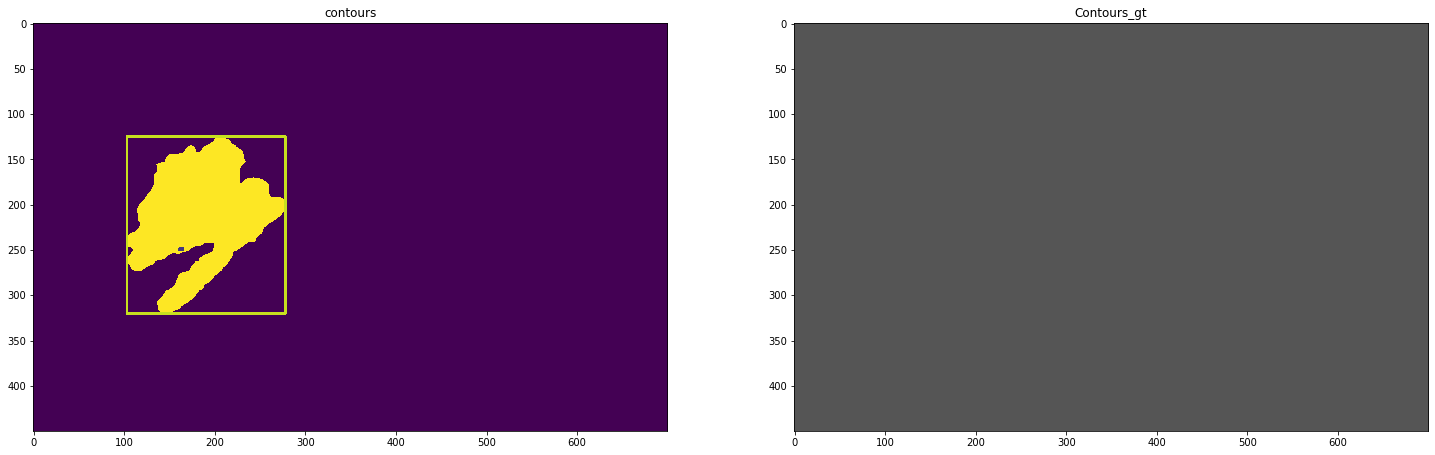

30
	IOU evaluation ..


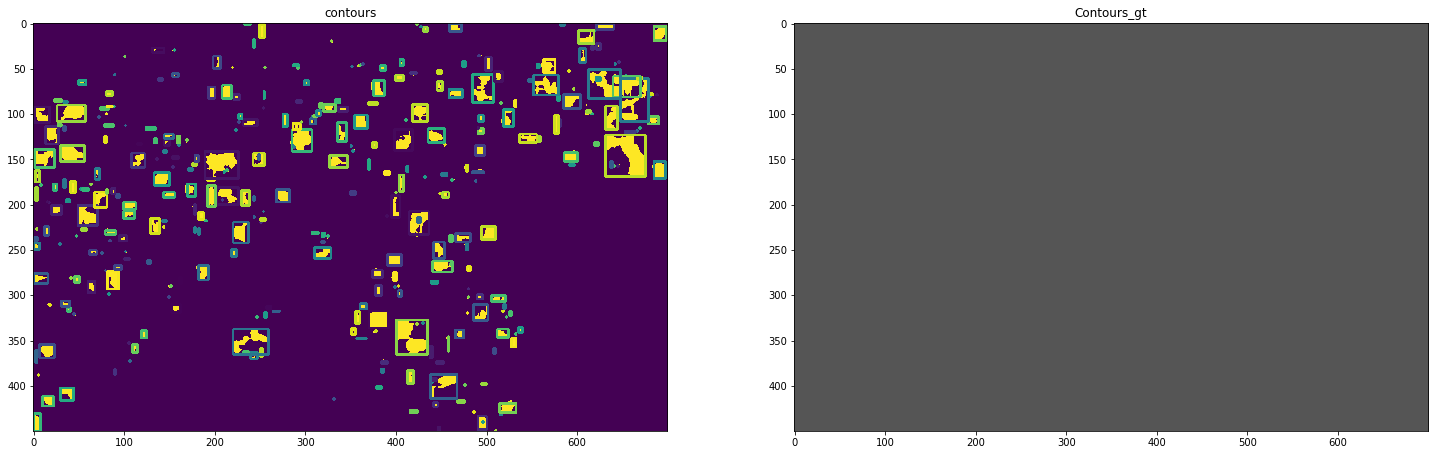

31
	IOU evaluation ..


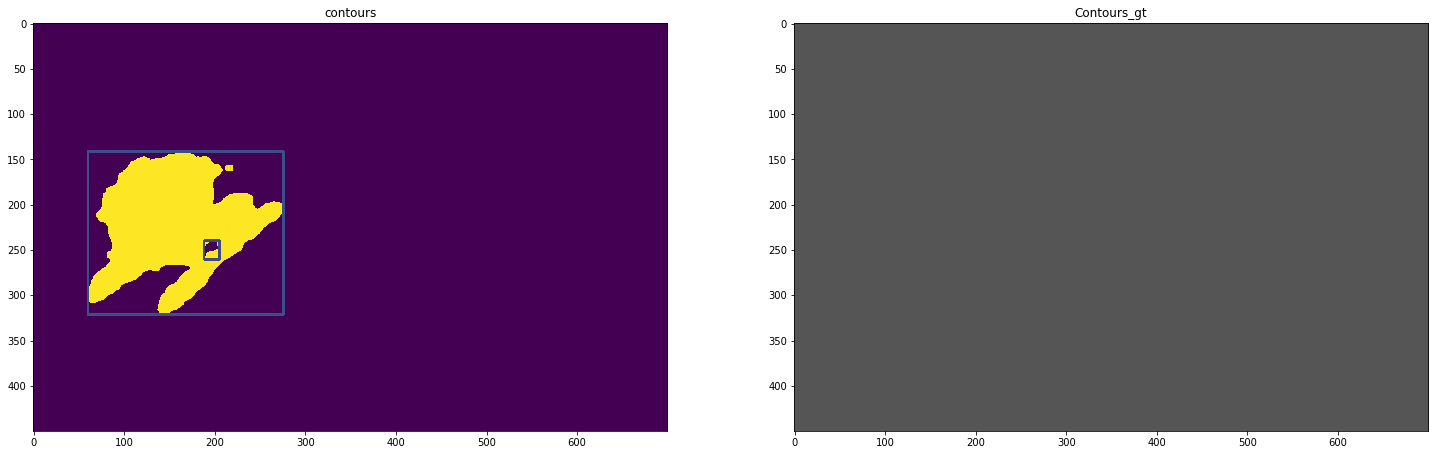

32
	IOU evaluation ..


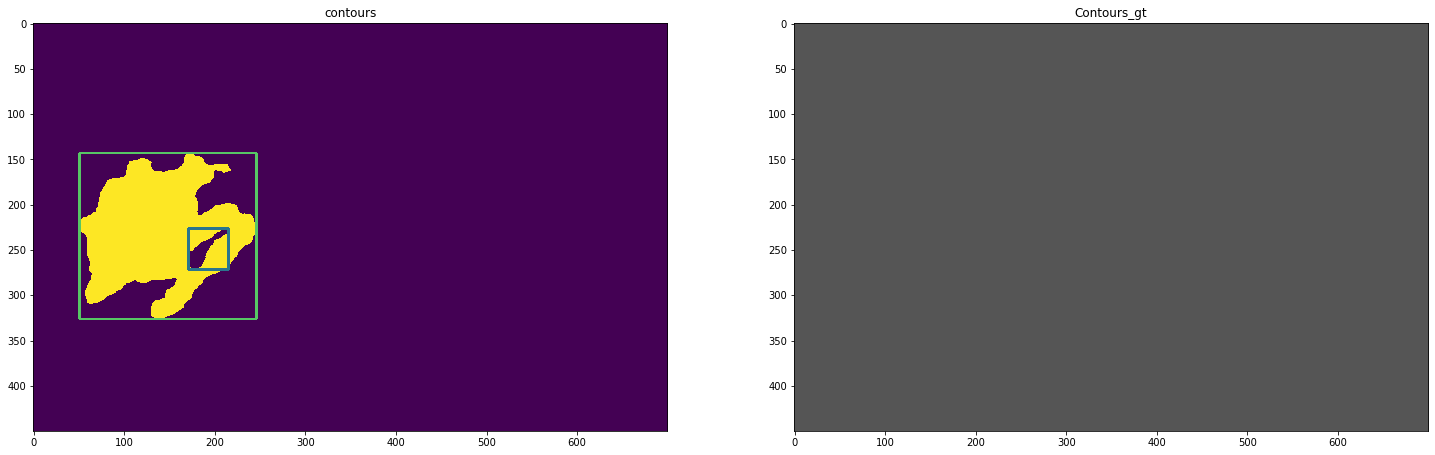

33
	IOU evaluation ..


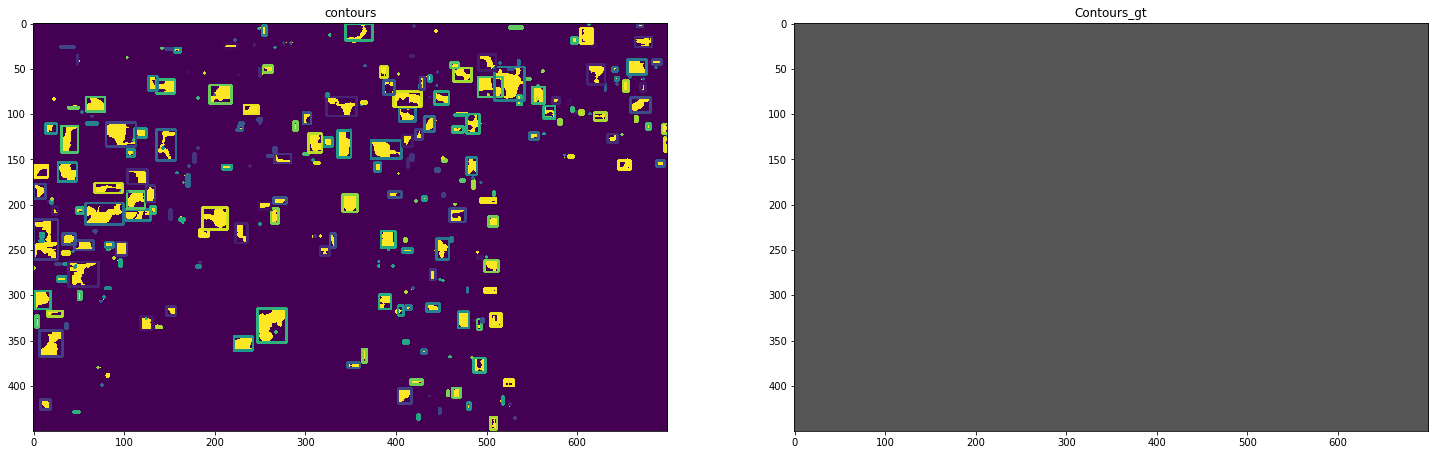

34
	IOU evaluation ..


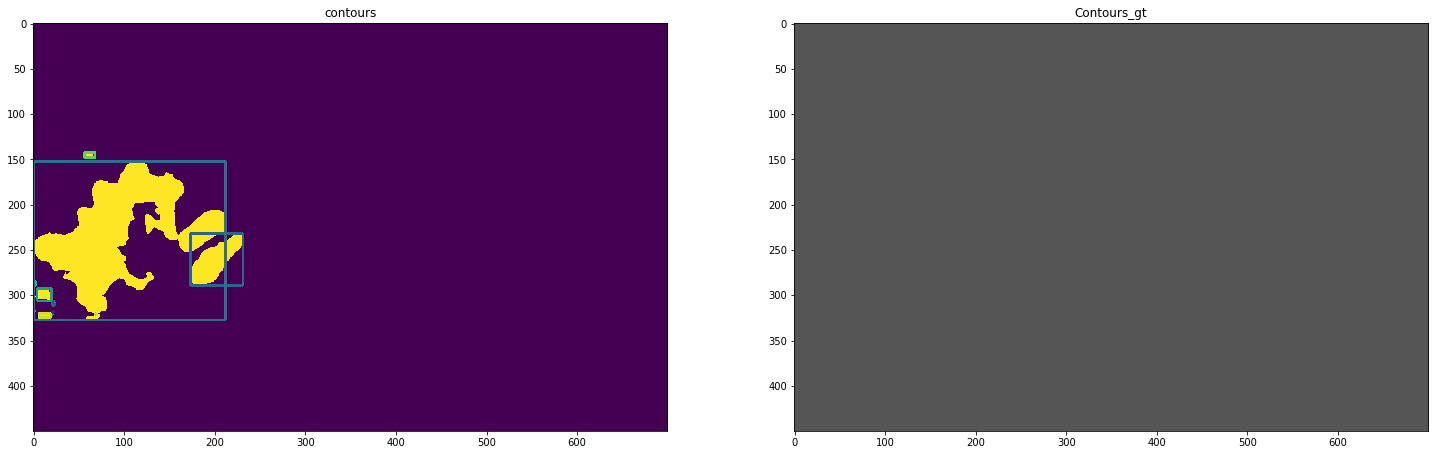

35
	IOU evaluation ..


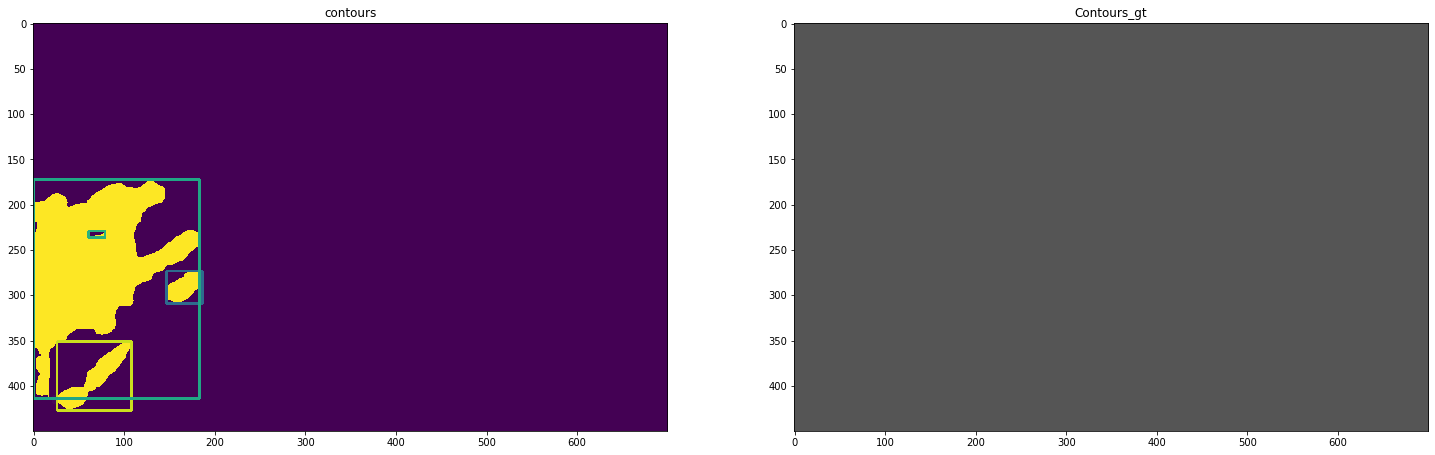

36
	IOU evaluation ..


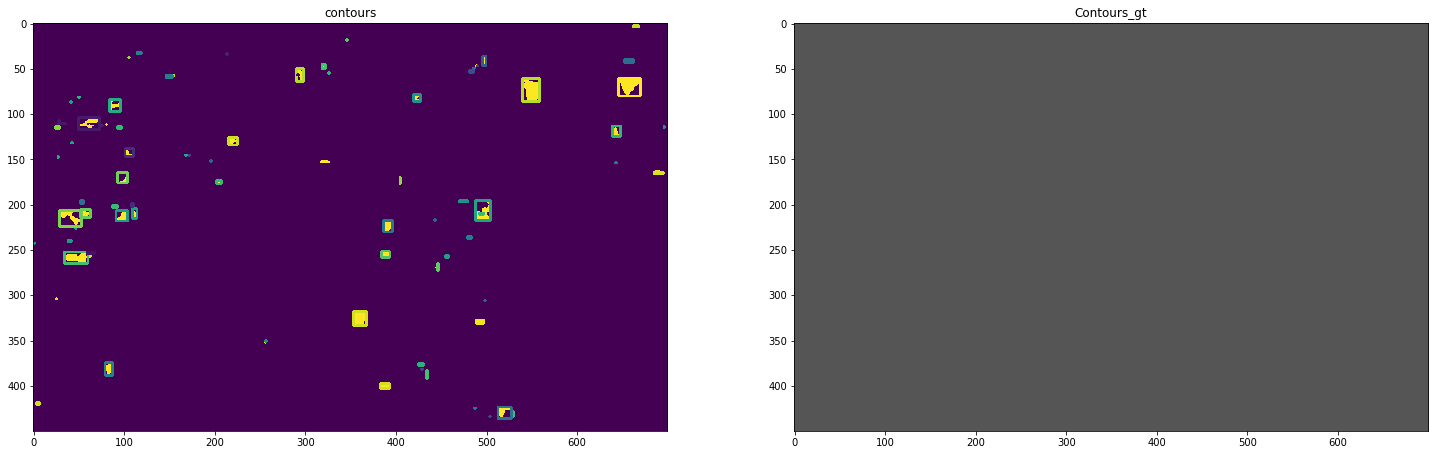

37
	IOU evaluation ..


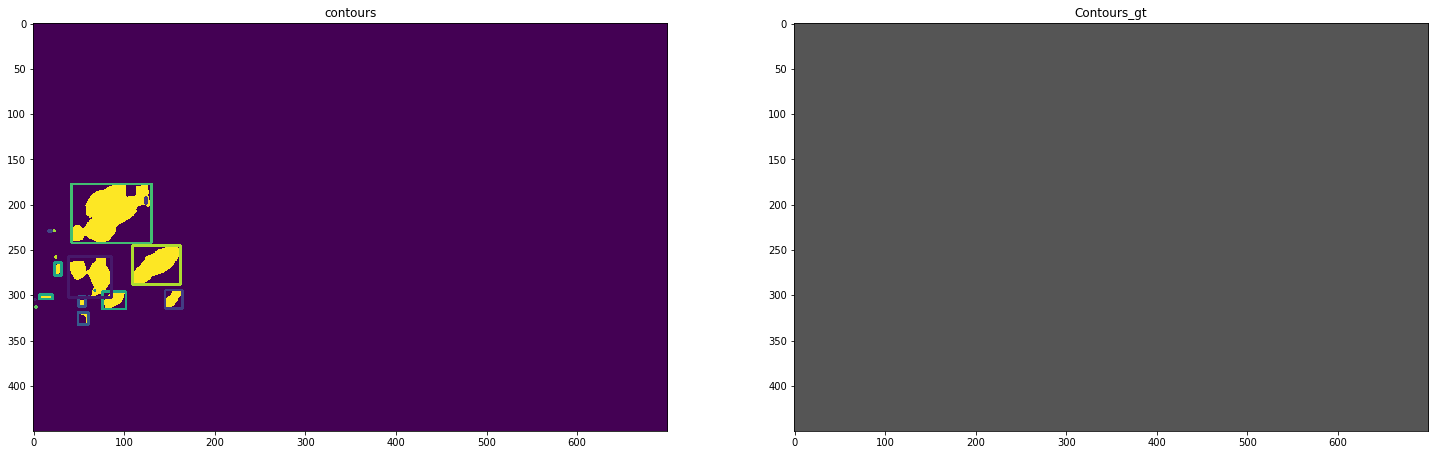

38
	IOU evaluation ..


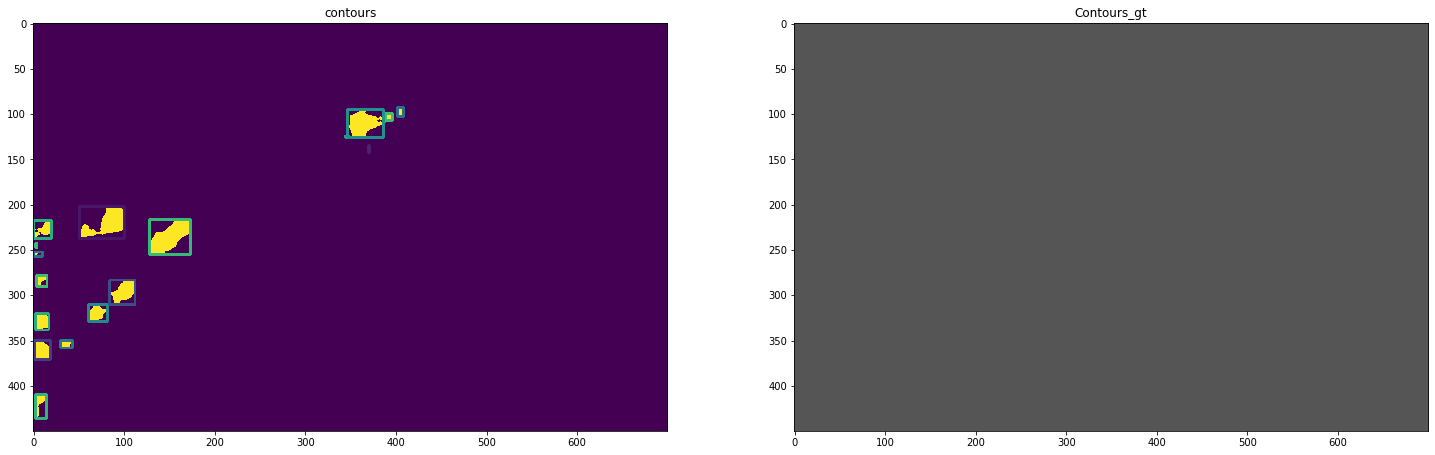

39
	IOU evaluation ..


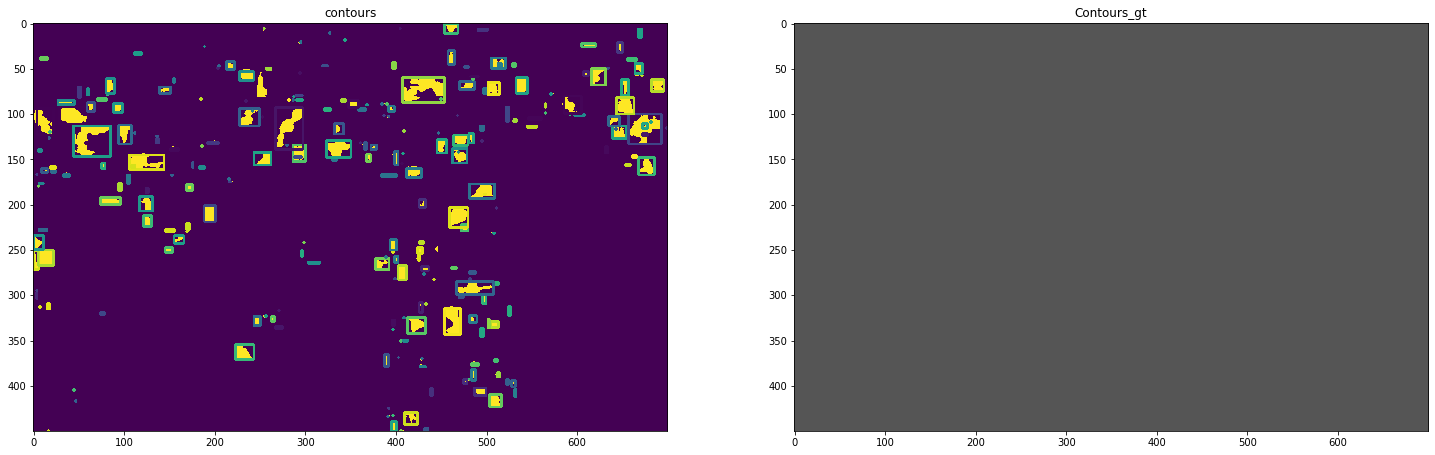

40
	IOU evaluation ..


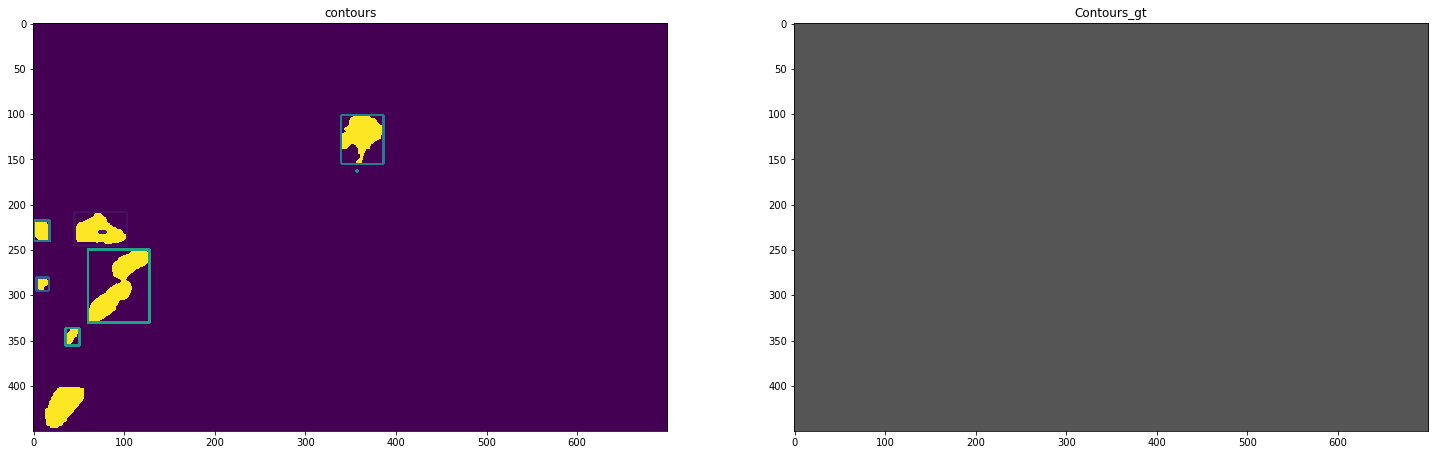

41
	IOU evaluation ..


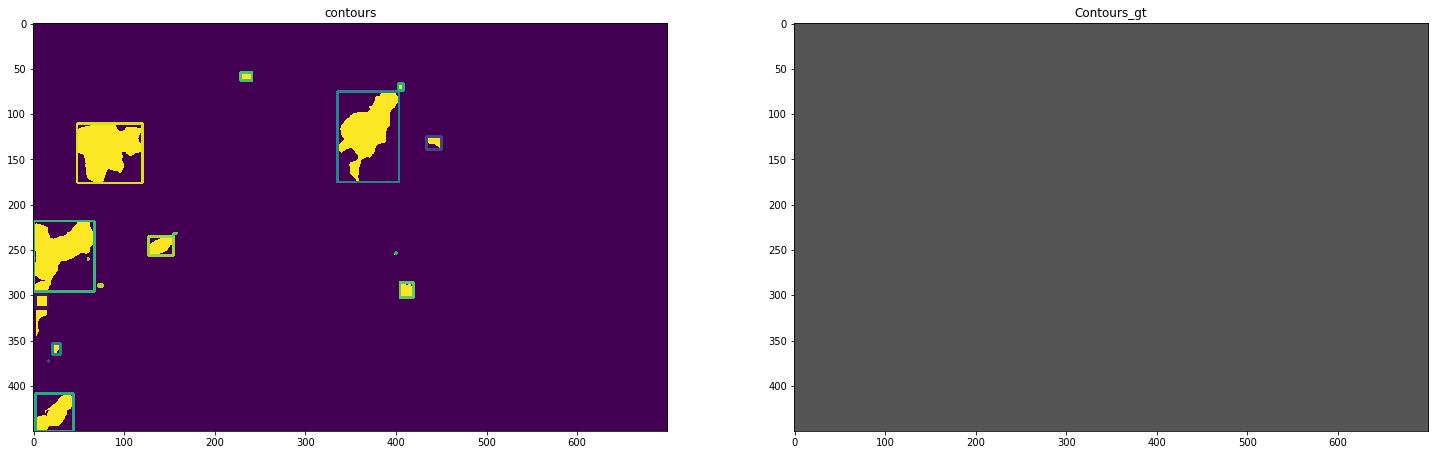

42
	IOU evaluation ..


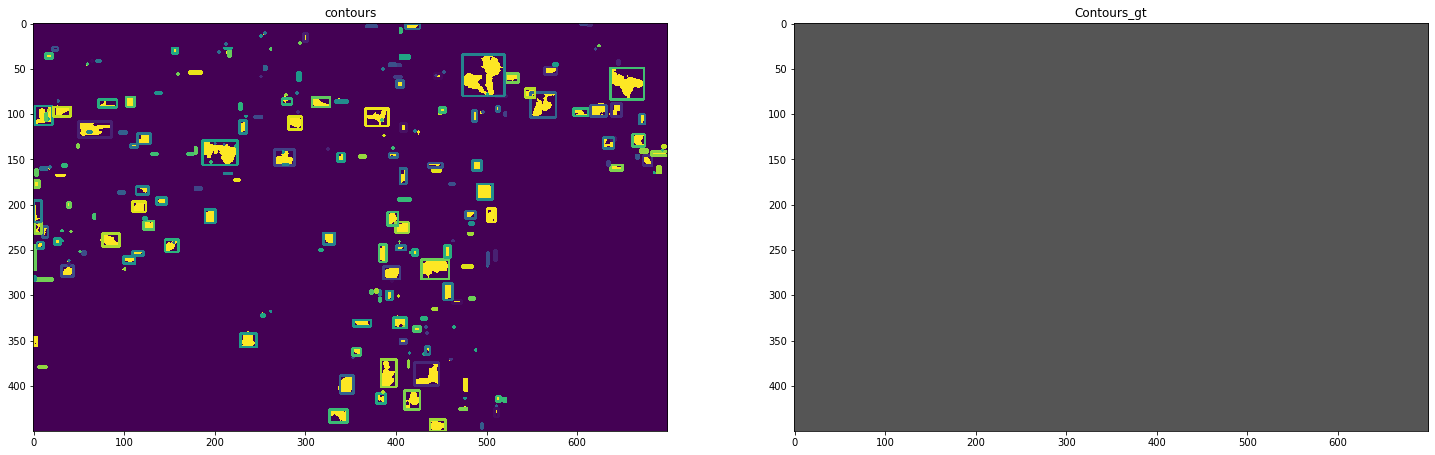

43
	IOU evaluation ..


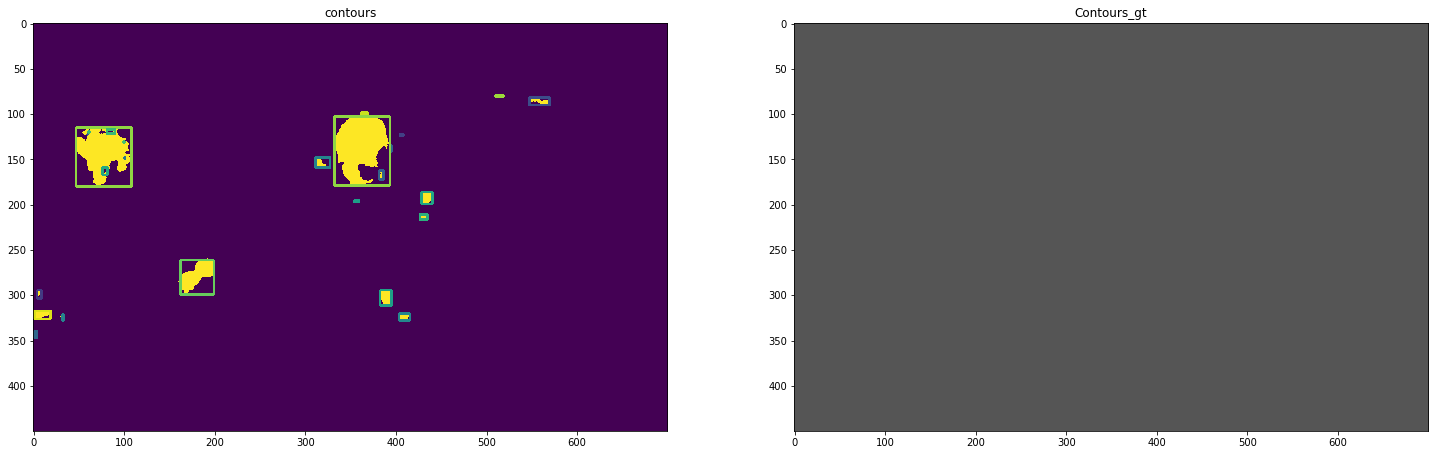

44
	IOU evaluation ..


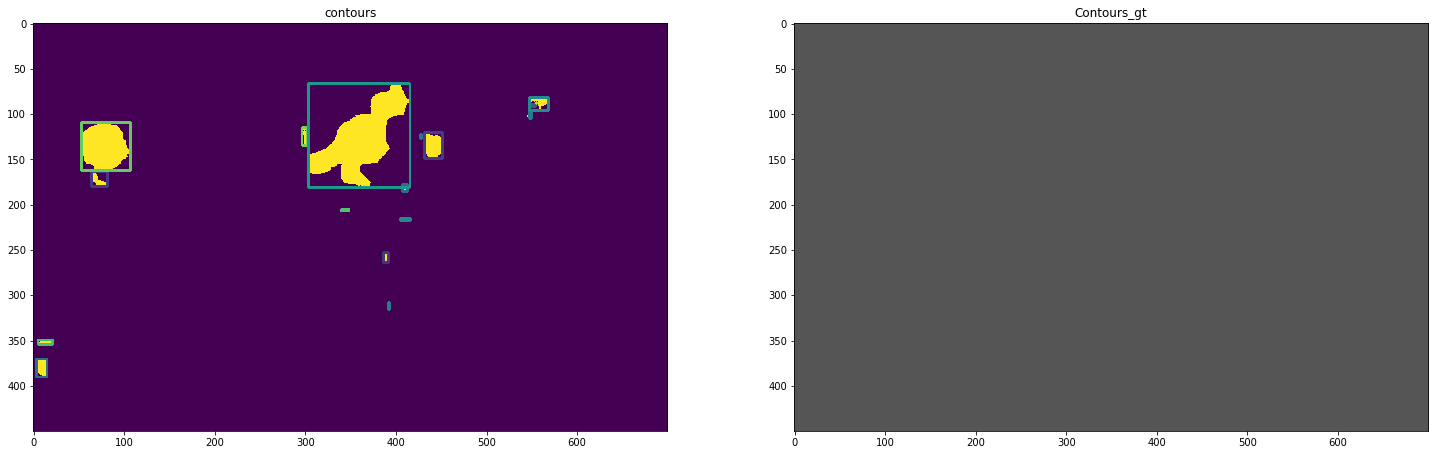

45
	IOU evaluation ..


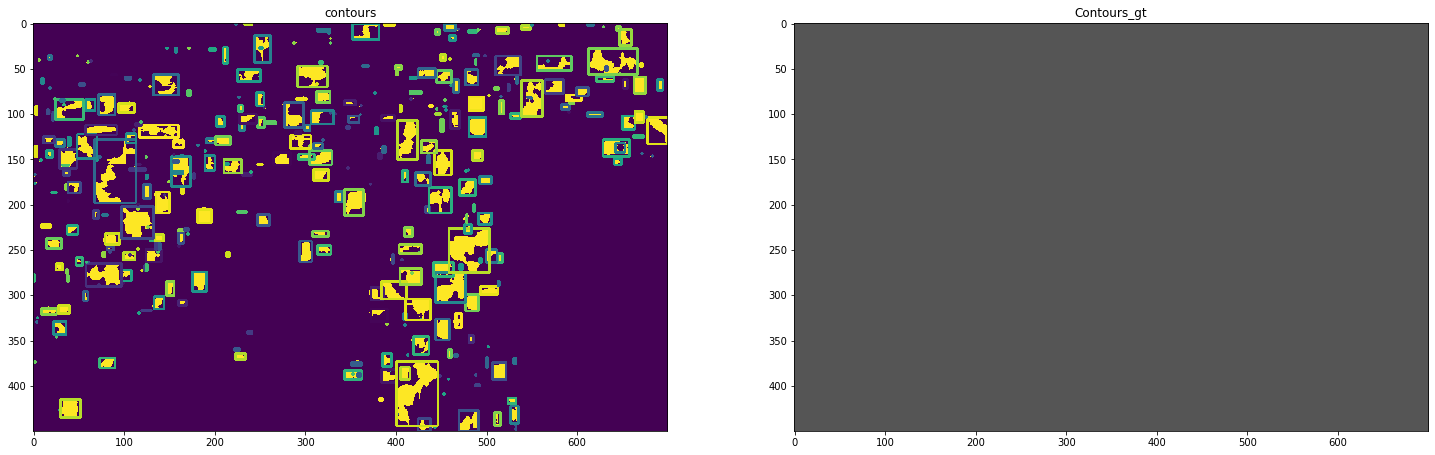

46
	IOU evaluation ..


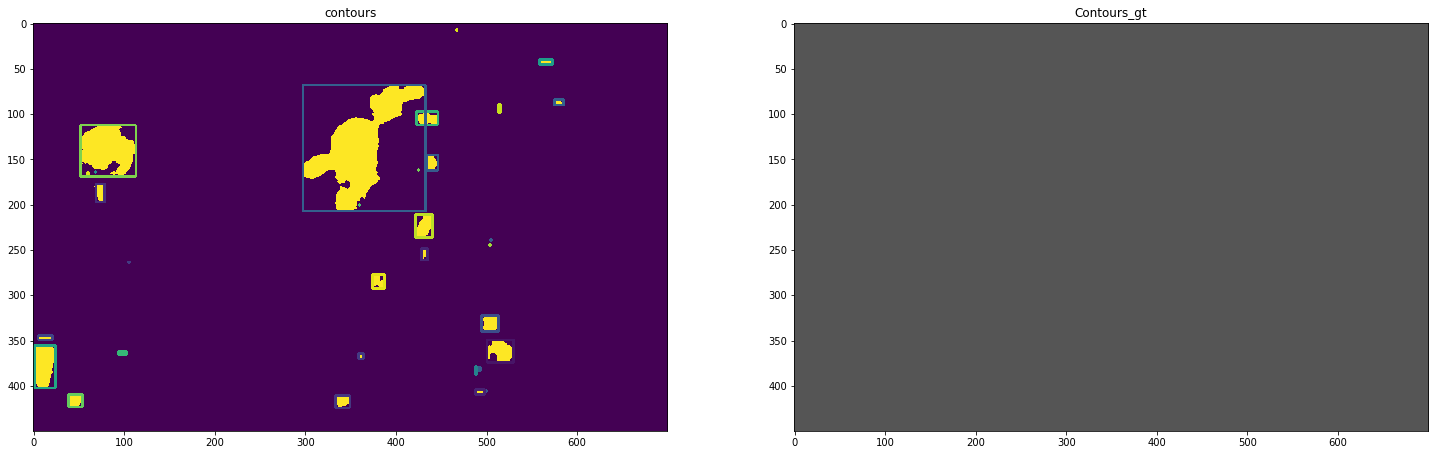

47
	IOU evaluation ..


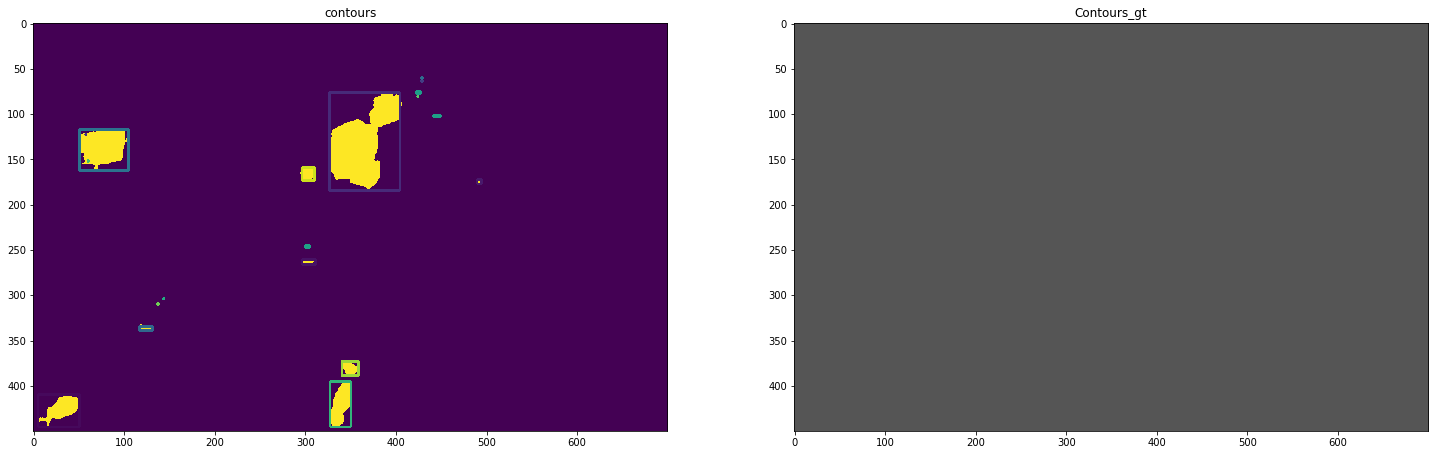

48
	IOU evaluation ..


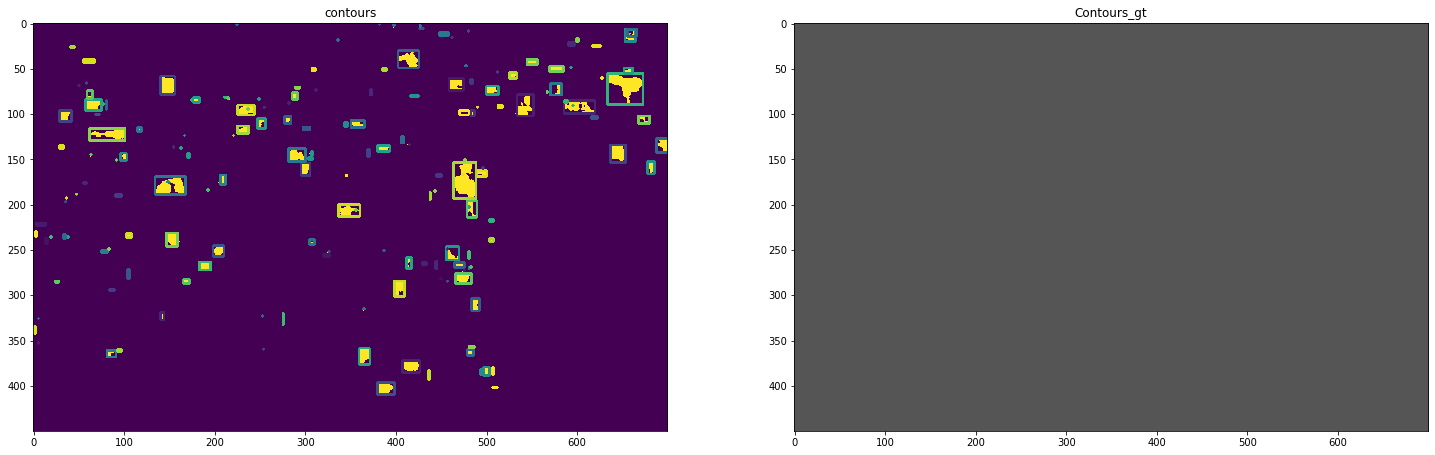

49
	IOU evaluation ..


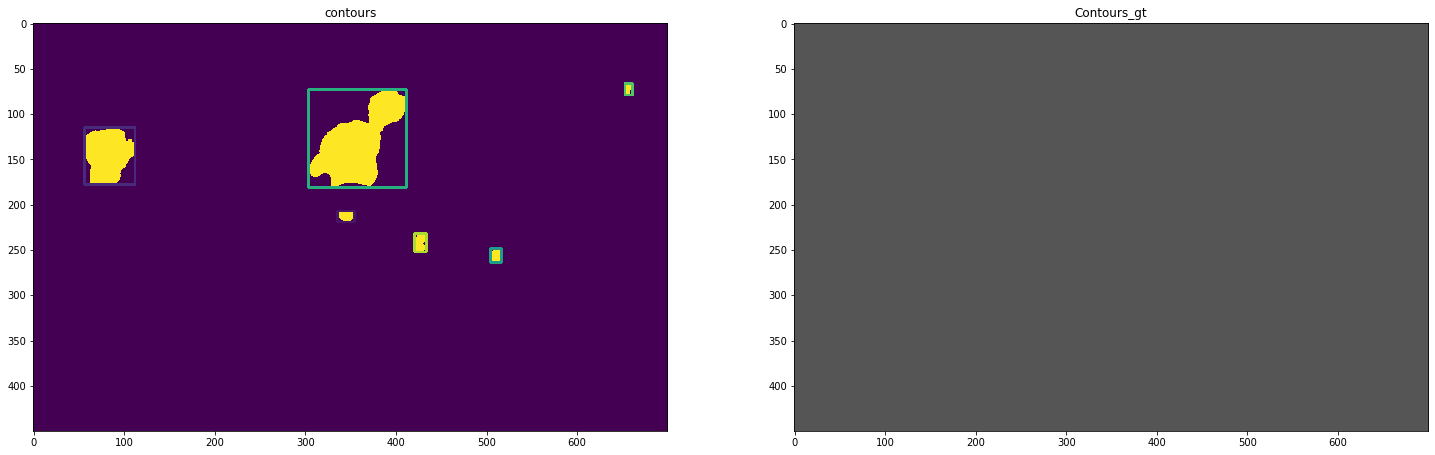

50
	IOU evaluation ..


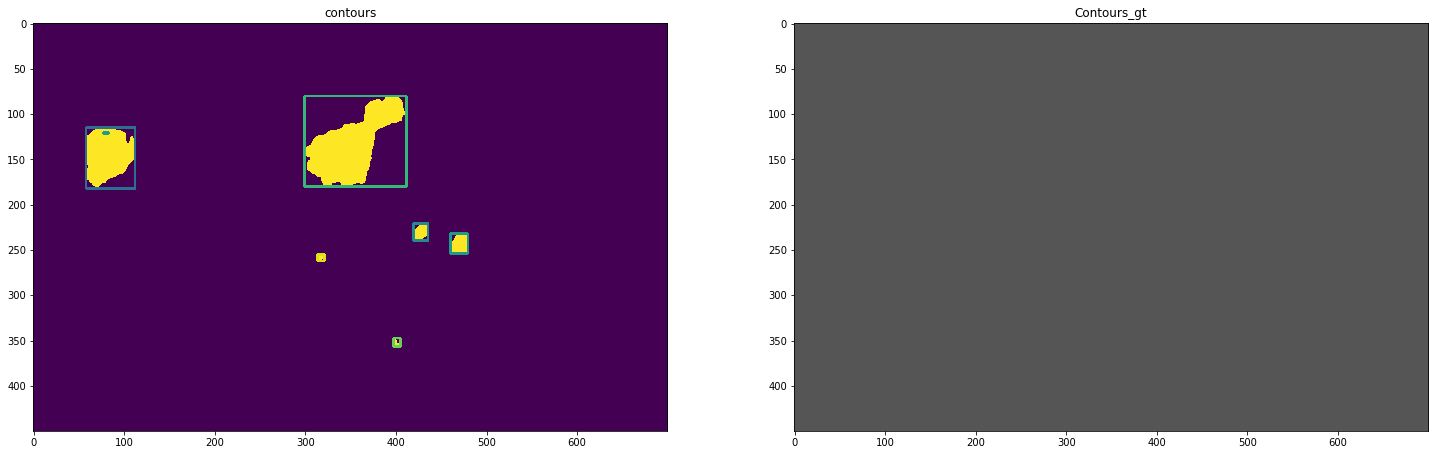

51
	IOU evaluation ..


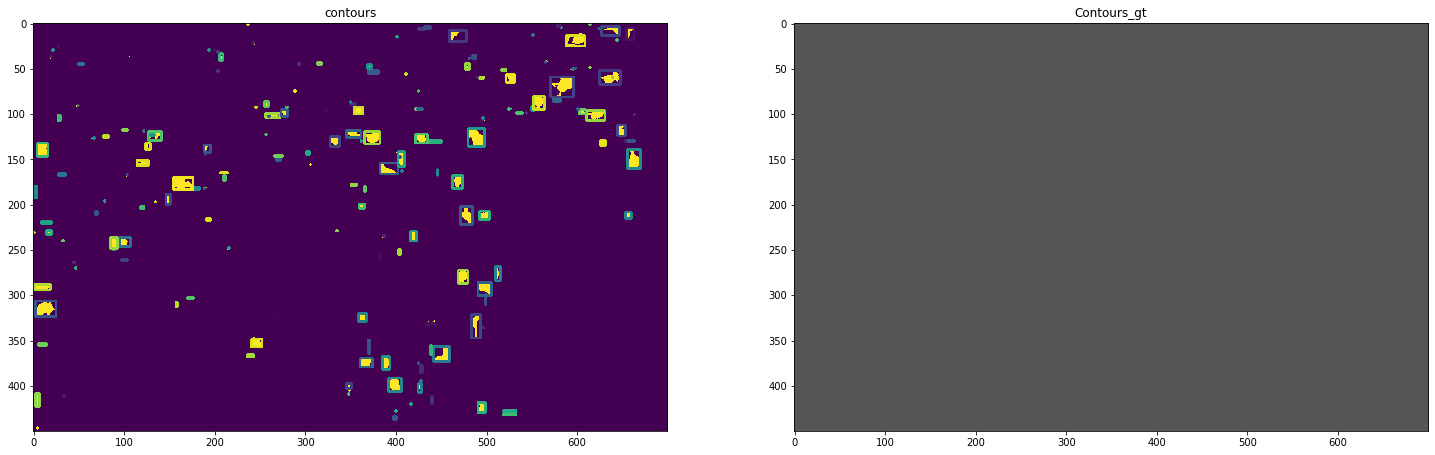

52
	IOU evaluation ..


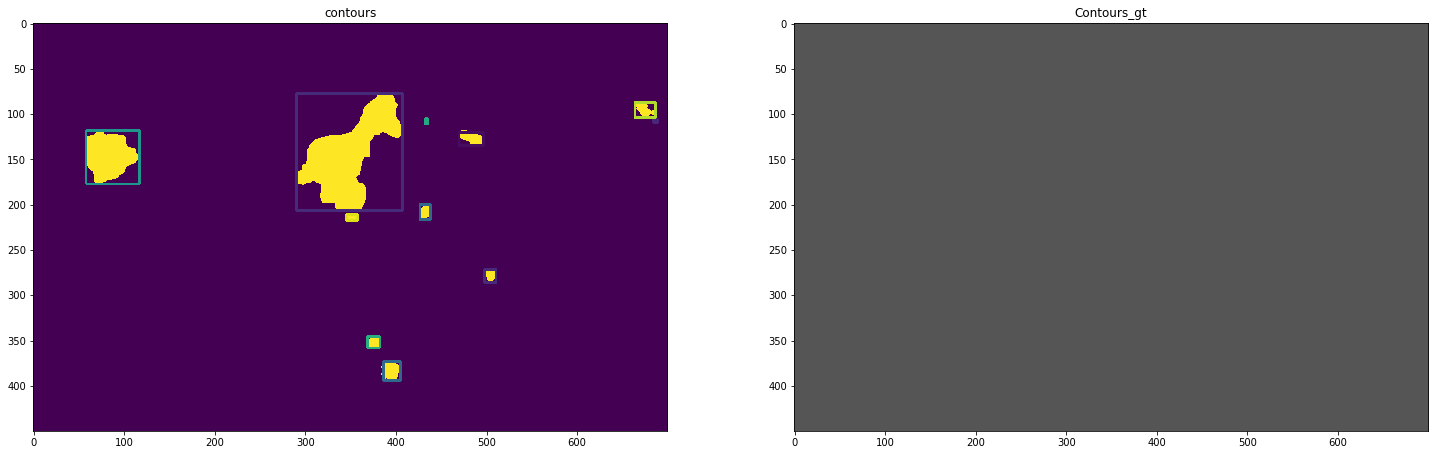

53
	IOU evaluation ..


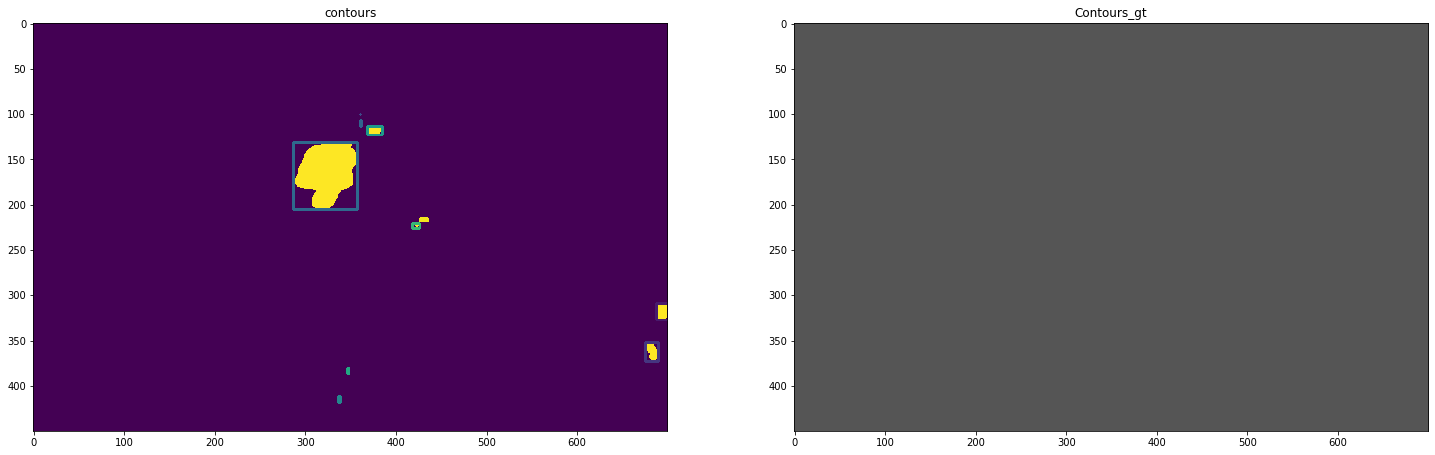

54
	IOU evaluation ..


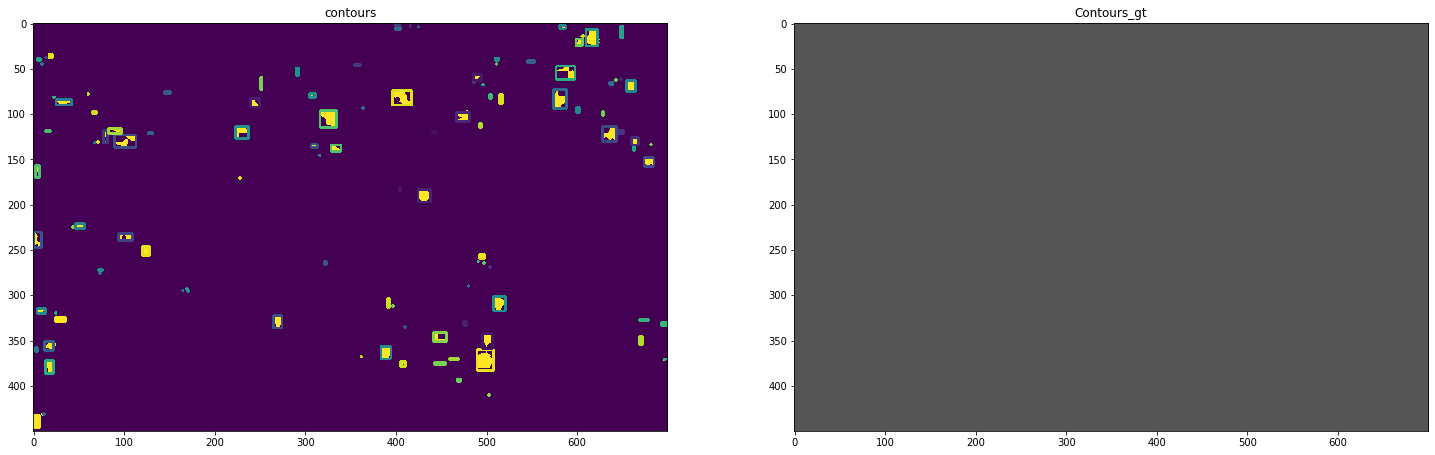

55
	IOU evaluation ..


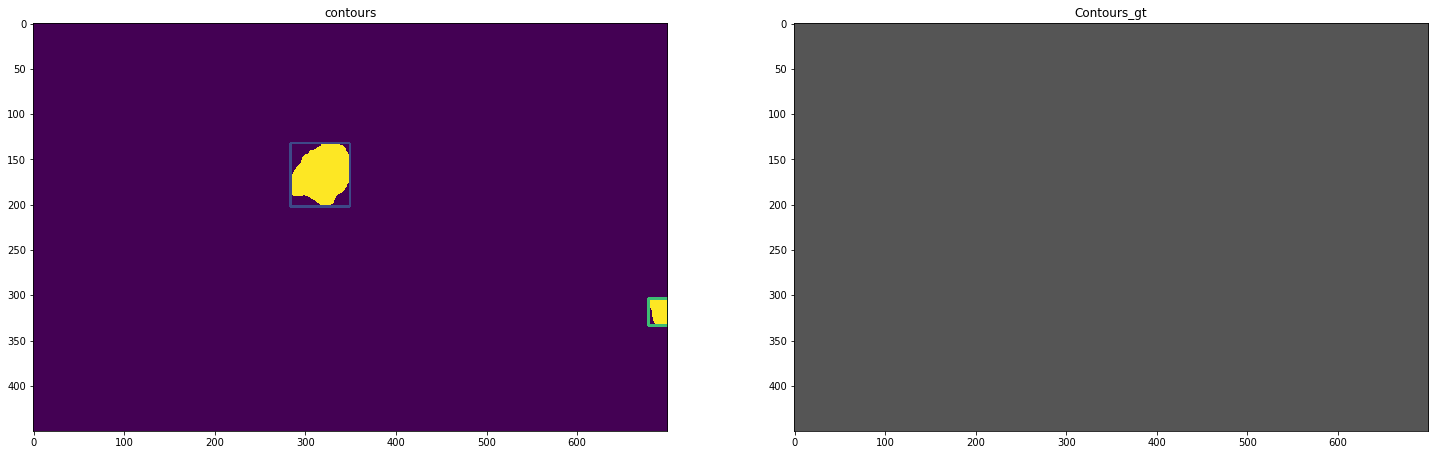

56
	IOU evaluation ..


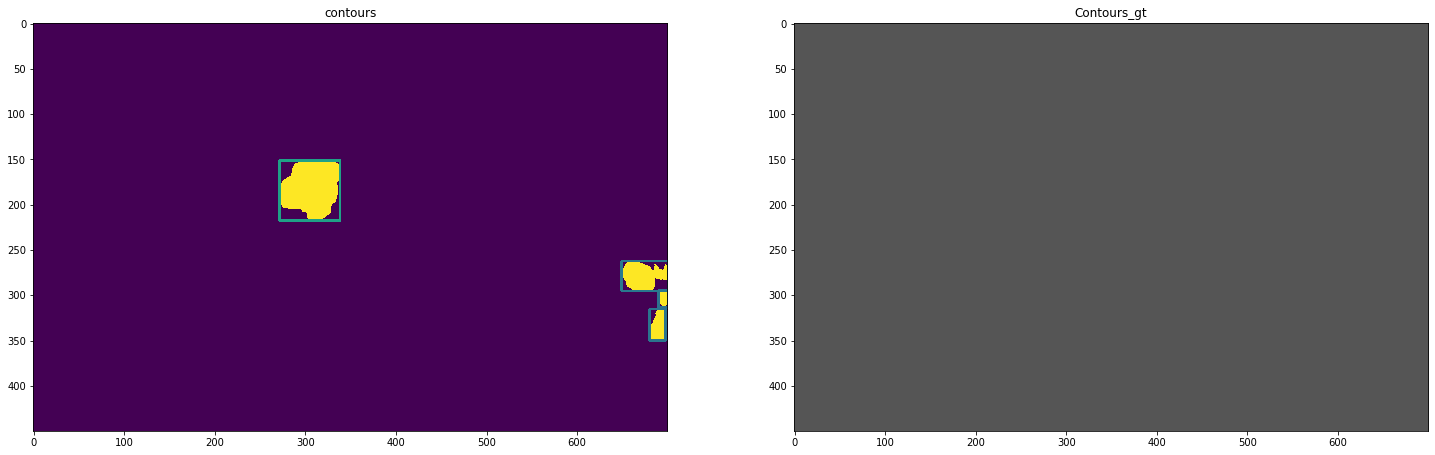

57
	IOU evaluation ..


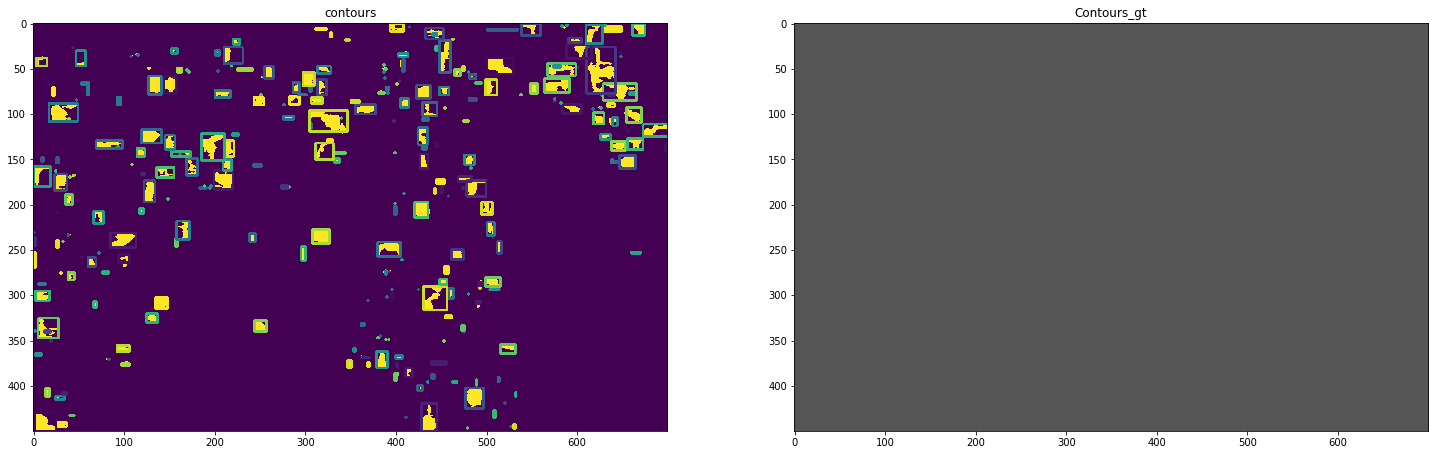

58
	IOU evaluation ..


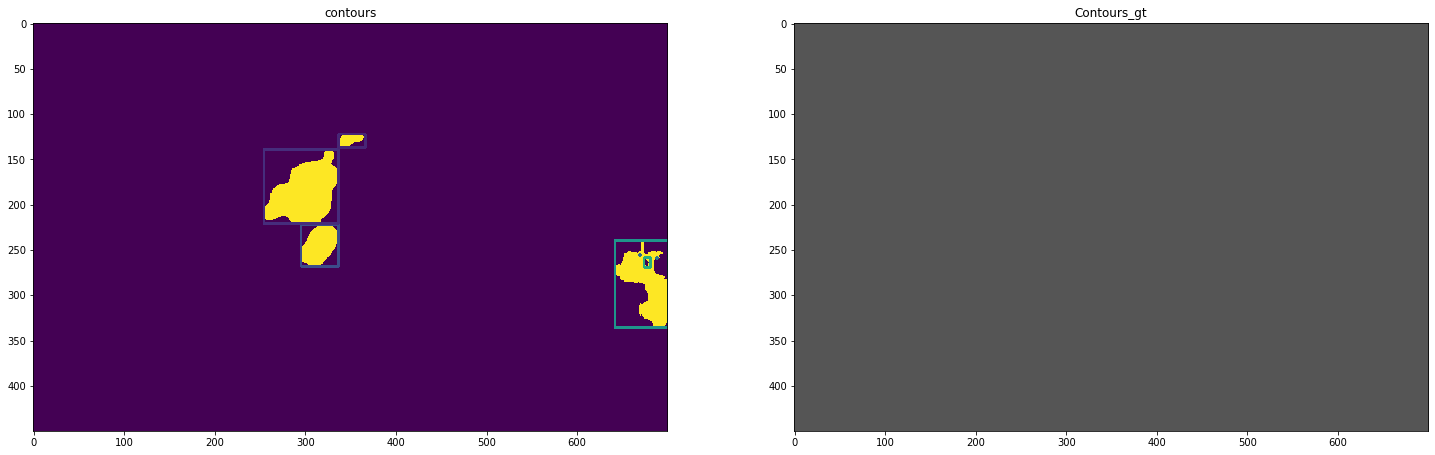

59
	IOU evaluation ..


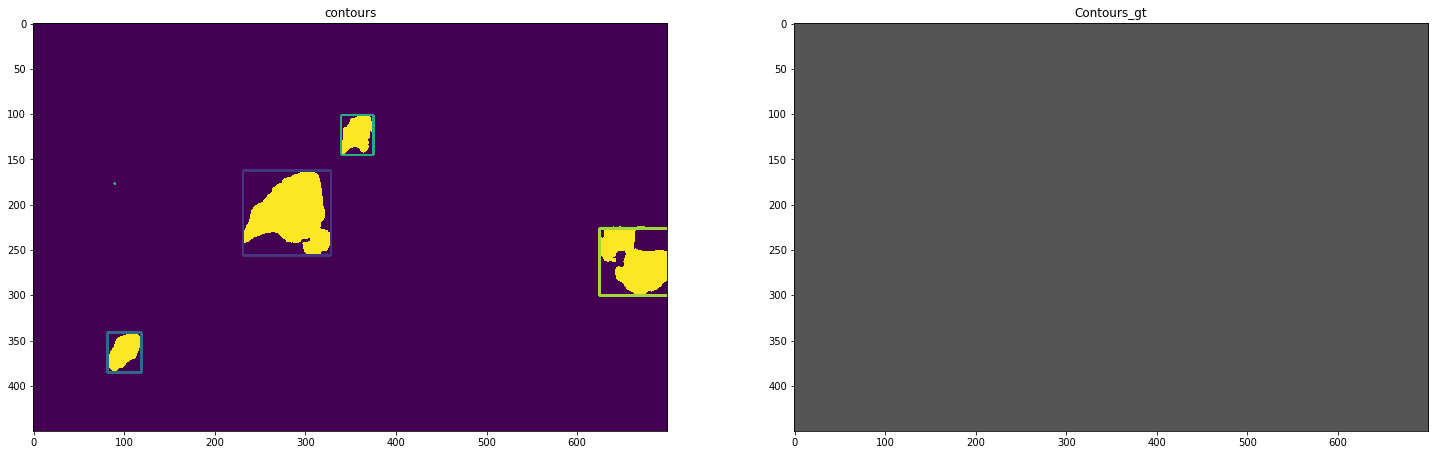

60
	IOU evaluation ..


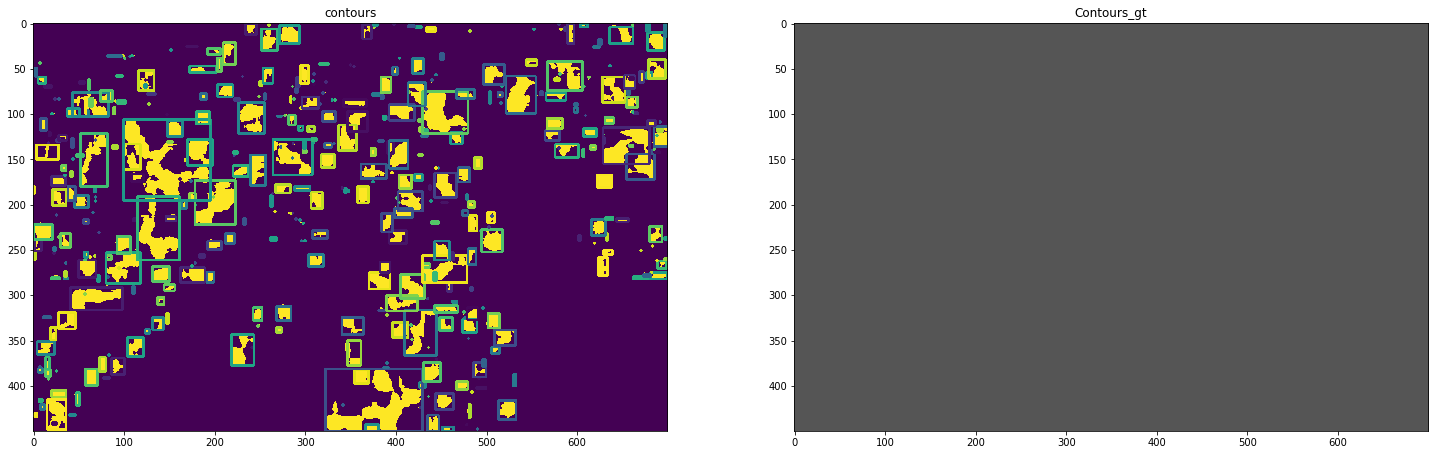

61
	IOU evaluation ..


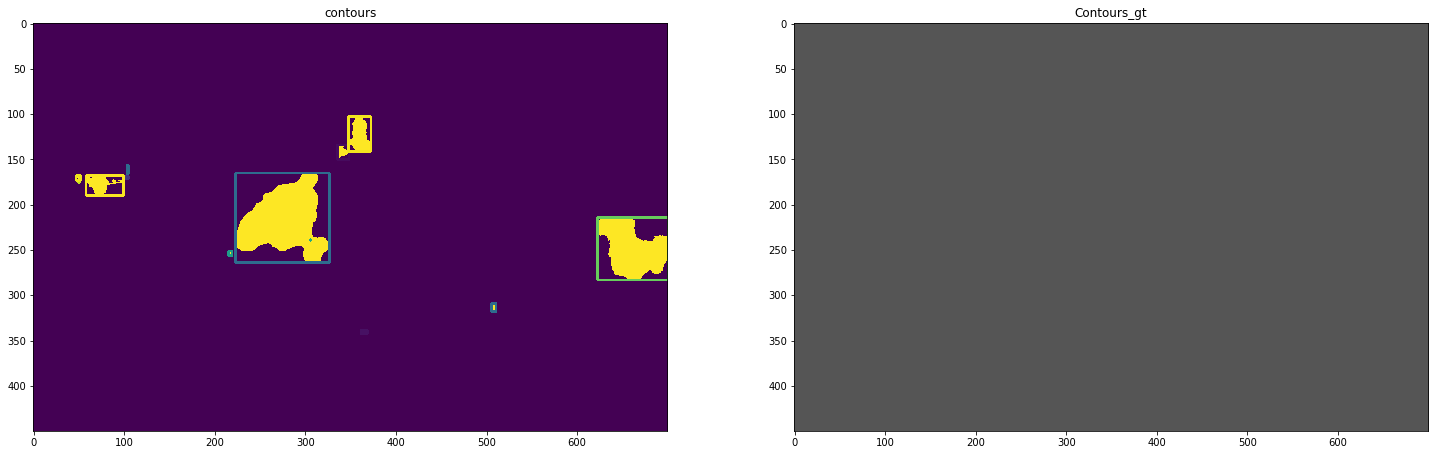

62
	IOU evaluation ..


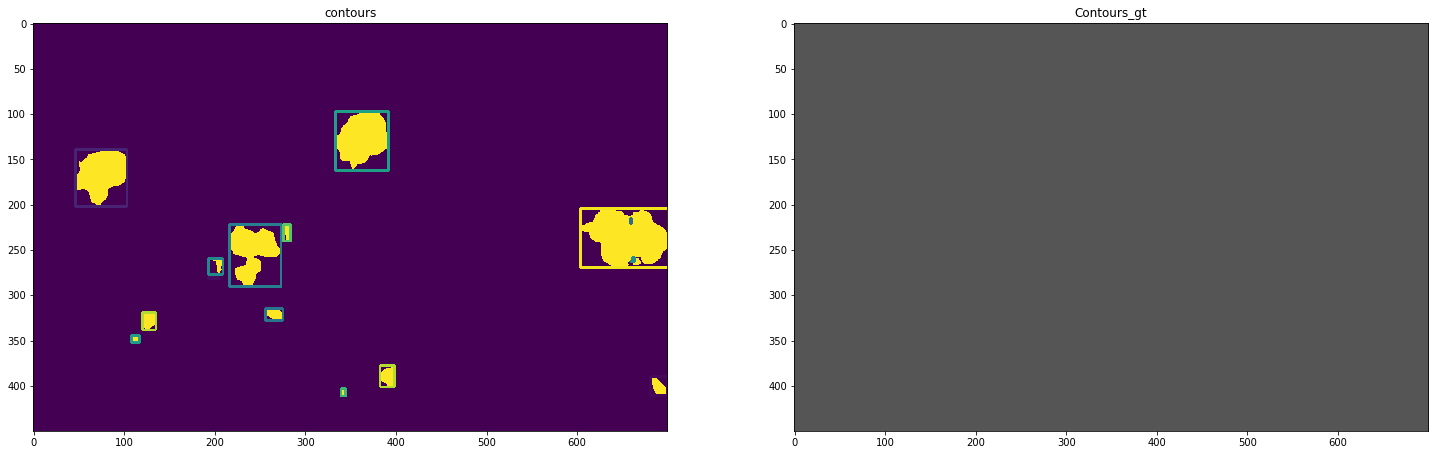

63
	IOU evaluation ..


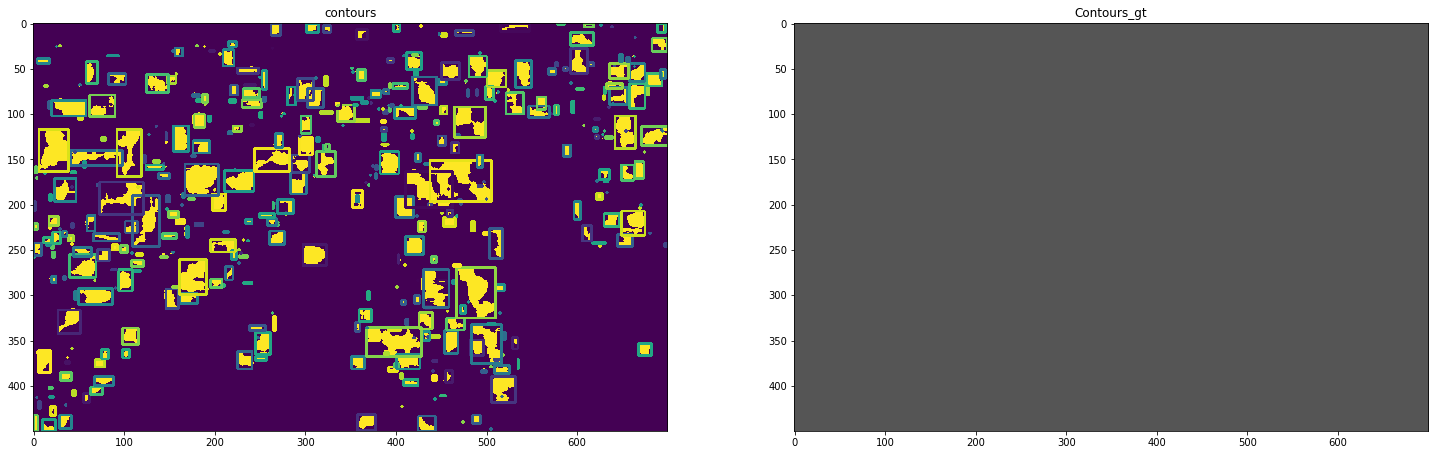

64
	IOU evaluation ..


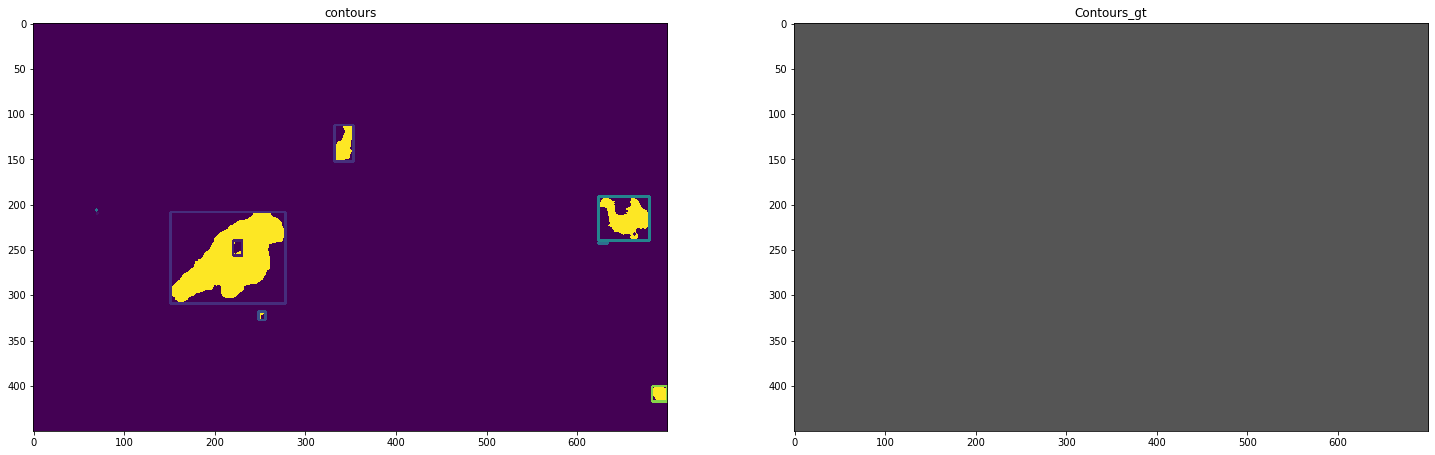

65
	IOU evaluation ..


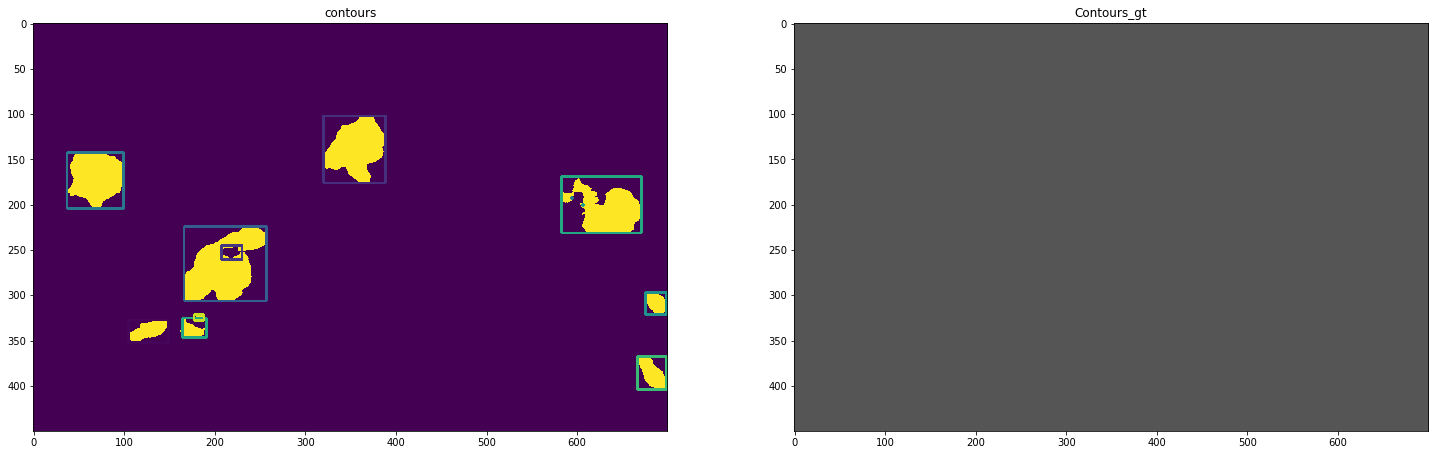

66
	IOU evaluation ..


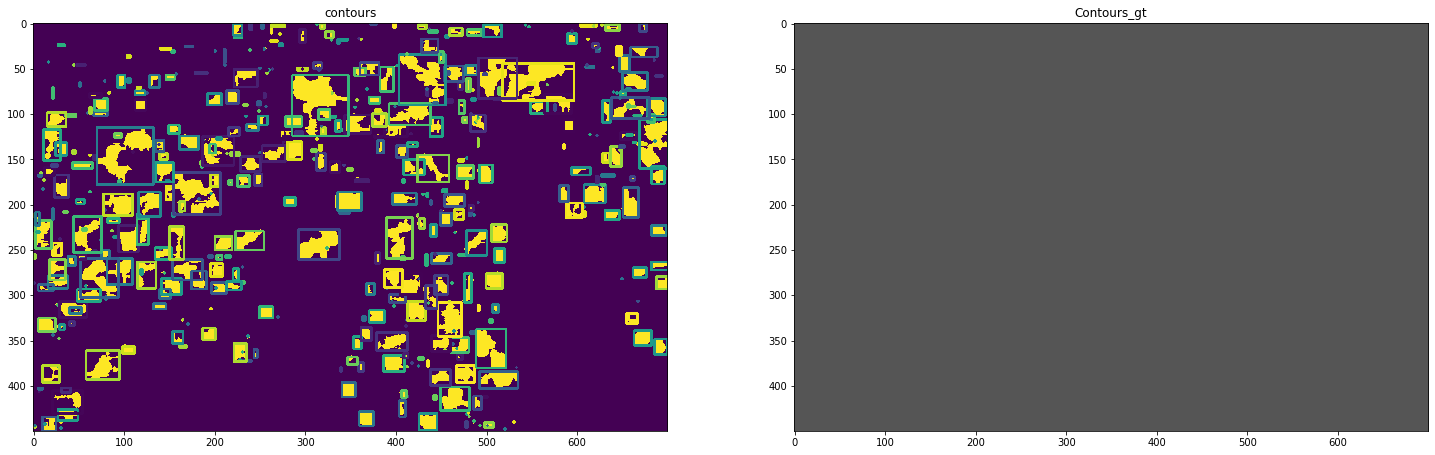

67
	IOU evaluation ..


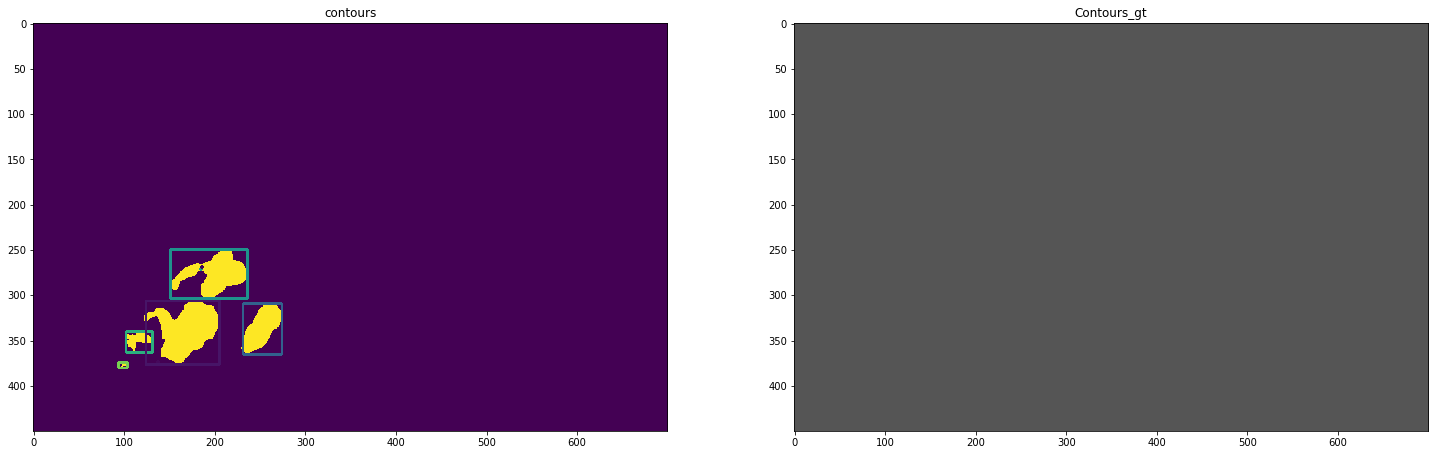

68
	IOU evaluation ..


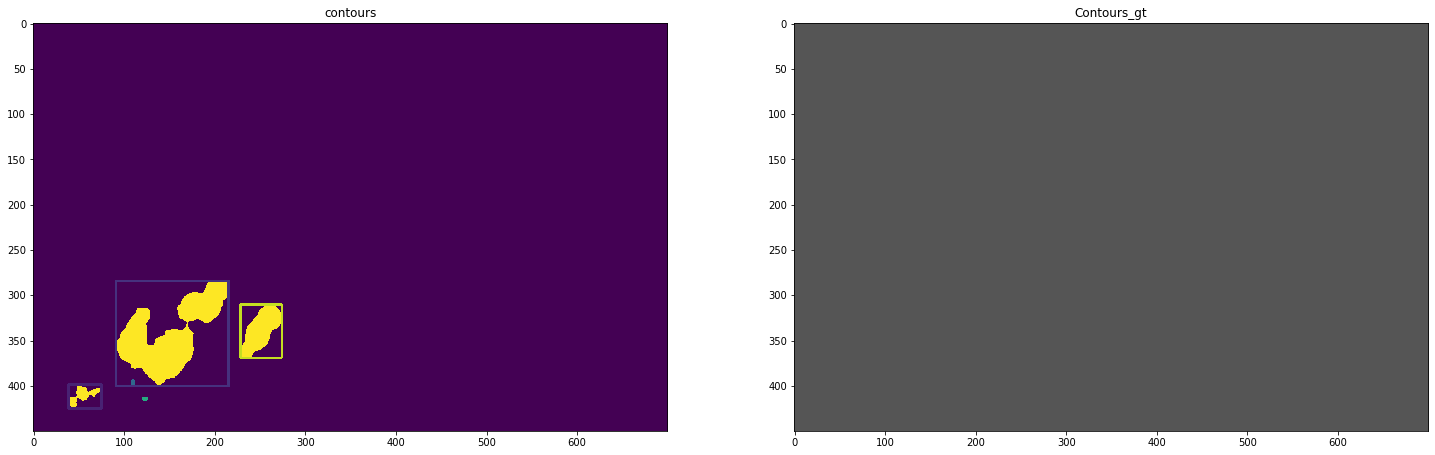

69
	IOU evaluation ..


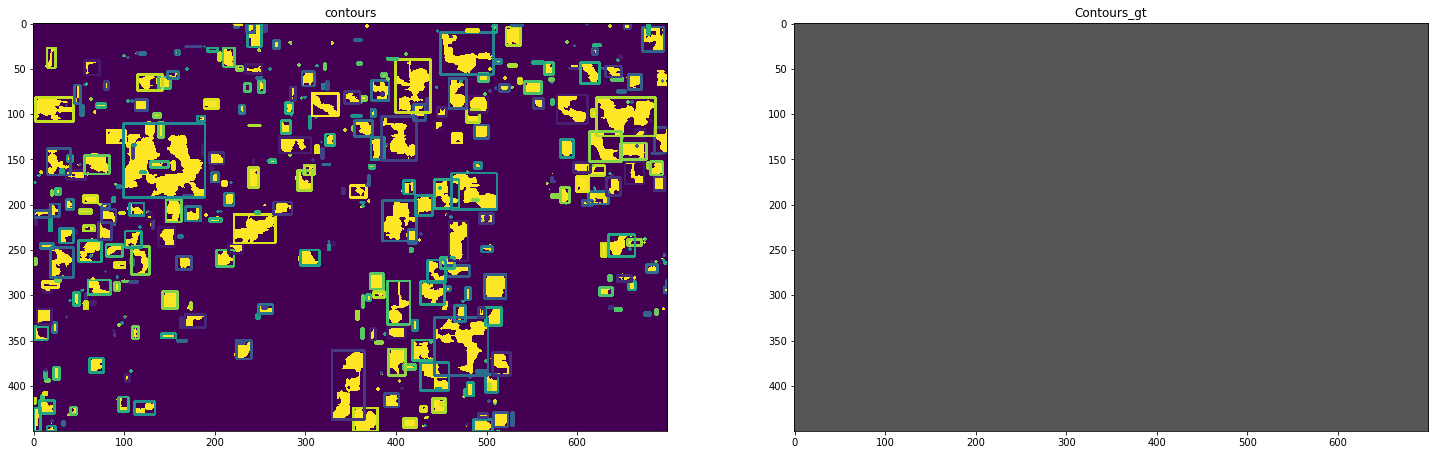

70
	IOU evaluation ..


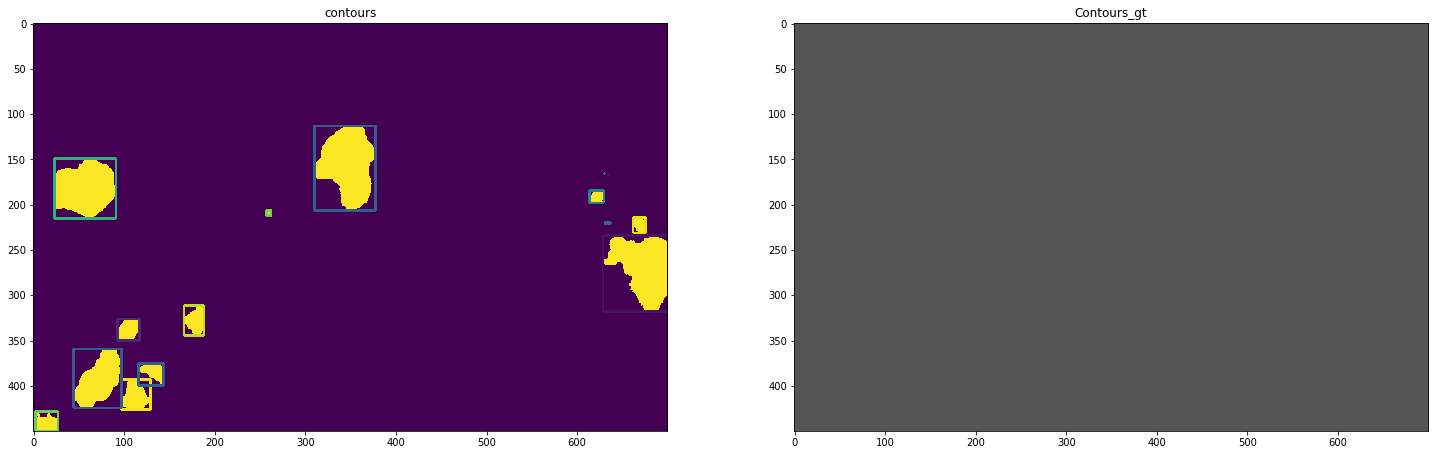

71
	IOU evaluation ..


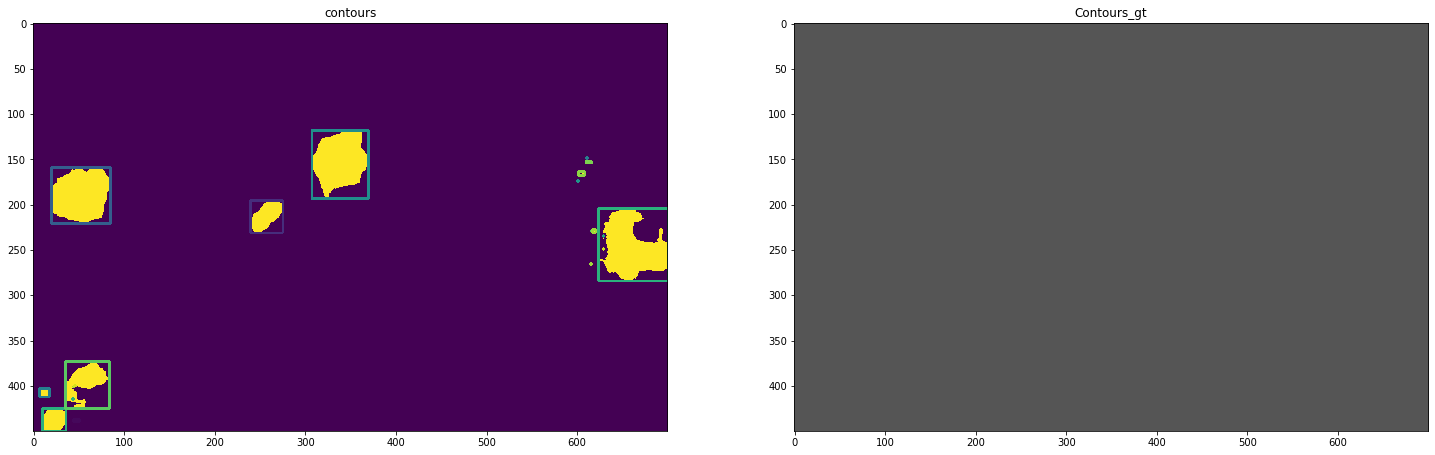

72
	IOU evaluation ..


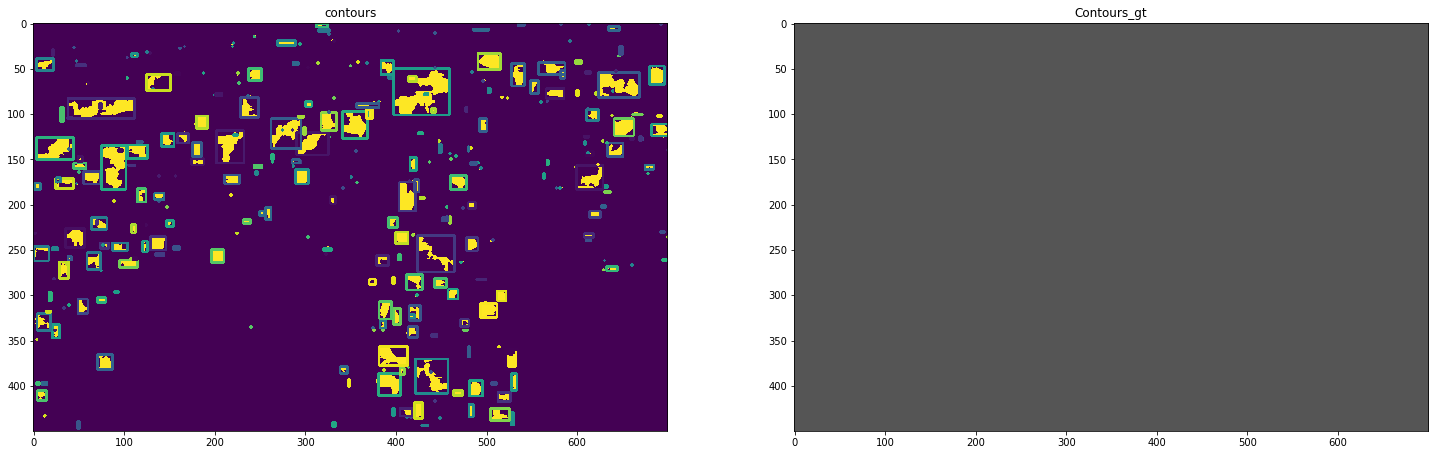

73
	IOU evaluation ..


In [ ]:
# Sources: https://docs.opencv.org/3.4.9/da/d0c/tutorial_bounding_rects_circles.html (with modifications)
#          https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ (with modifications)

threshold = 100
total_time = datetime.timedelta(seconds=0)
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])
avg_iou = {'Bad_Weather': [], 'Baseline': [], 'Night_Videos': []}
j = 0
tot = 0

for subset in glob.glob('.\CDNet\*'):

    print('Processing ' + subset + ' ..')
    
    it = 0
    
    if 'Baseline' in subset:
        bname = r'.\CDNet\Baseline\pedestrians'
        continue
    elif 'Bad_Weather' in subset:
        bname = r'.\CDNet\Bad_Weather\blizzard'
        continue
    else:
        bname = r'.\CDNet\Night_Videos\fluidHighway'
    
    iou, sum_iou = 0, 0
    
    glob_min_iou = 100000
    glob_max_iou = -100000
    
    for img, gt in zip(glob.glob(bname+'\input\*.jpg'), glob.glob(bname+'\groundtruth\*.png')):
        
        print(it)
        if it == 0:
            old_frame = cv2.imread(img)

            old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

            hsv = np.zeros_like(old_frame)
            hsv[...,1] = 255

            it += 1
            total_time = datetime.timedelta(seconds=0)

        elif it == 1000:
            print('break')
            break
            
        else:
            # read frame and groundtruth
            frame = cv2.imread(img)
            gt = cv2.imread(gt)
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # calculate optical flow and run time
            prev_time = time.time()

            flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

            run_time = datetime.timedelta(seconds=time.time() - prev_time)
            total_time += run_time

            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

            k = cv2.waitKey(60) & 0xff
            if k == 27:
                break

            #IOU eval
            print('\tIOU evaluation ..')
            
            #BBoxes generation
            
            ret, threshed_img = cv2.threshold(cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY), 25, 255, cv2.THRESH_BINARY)
            ret_gt, threshed_img_gt = cv2.threshold(cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY), 100, 255, cv2.THRESH_BINARY)
            
            _, contours, _ = cv2.findContours(threshed_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            _, contours_gt, _ = cv2.findContours(threshed_img_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                        
            contours_poly = [None]*len(contours)
            boundRect = [None]*len(contours)
            for i, c in enumerate(contours):
                contours_poly[i] = cv2.approxPolyDP(c, 3, True)
                boundRect[i] = cv2.boundingRect(contours_poly[i])
                
            contours_poly_gt = [None]*len(contours_gt)
            boundRect_gt = [None]*len(contours_gt)
            for i, c in enumerate(contours_gt):
                print(i)
                contours_poly_gt[i] = cv2.approxPolyDP(c, 3, True)
                boundRect_gt[i] = cv2.boundingRect(contours_poly_gt[i])
            
            for i in range(len(contours)):
                color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
                cv2.rectangle(threshed_img, (int(boundRect[i][0]), int(boundRect[i][1])), \
                  (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)

            for i in range(len(contours_gt)):
                color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
                cv2.rectangle(gt, (int(boundRect_gt[i][0]), int(boundRect_gt[i][1])), \
                  (int(boundRect_gt[i][0]+boundRect_gt[i][2]), int(boundRect_gt[i][1]+boundRect_gt[i][3])), color, 2)
            
            fig2 = plt.figure(figsize=(25, 25))
            
            x = fig2.add_subplot(1, 2, 1)
            x.set_title('contours')
            plt.imshow(threshed_img)
            
            y = fig2.add_subplot(1, 2 , 2)
            y.set_title('Contours_gt')
            plt.imshow(gt)
            plt.show()
            
            #IOU calcul
            n = 0
            sum_iou = 0
            if len(contours) != 0 and len(contours_gt) != 0:
                max_iou = 0.0
                min_iou = 1.0
                for l in range(len(contours)):
                    for k in range(len(contours_gt)):
                        iou = bb_intersection_over_union((boundRect_gt[k][0], boundRect_gt[k][1], boundRect_gt[k][0]+boundRect_gt[k][2], boundRect_gt[k][1]+boundRect_gt[k][3]), (boundRect[l][0], boundRect[l][1], boundRect[l][0]+boundRect[l][2], boundRect[l][1]+boundRect[l][3]))
                        if iou > 0.0:
                            #print(iou)
                            n += 1
                        if iou < min_iou:
                            min_iou = iou
                        if iou > max_iou:
                            max_iou = iou
                        if iou < glob_min_iou:
                            glob_min_iou = iou
                        if iou > glob_max_iou:
                            glob_max_iou = iou
                        sum_iou += iou

                if n >= 0:
                    print('\t\tIOU score for image '+str(it)+': '+str(max_iou))
                    avg_iou[subset.split("\\")[2]].append(max_iou)
                    tot += 1
            
            old_gray = frame_gray
            it += 1
    
    print('\tTotal = '+str(tot))
    print('\tAverage IOU score for subset '+subset+' = ' + str(sum(avg_iou[subset.split("\\")[2]])/tot) + '\n')
    print('\tMax IOU score for subset '+subset+' = ' + str(glob_max_iou) + '\n')
    print('\tMin IOU score for subset '+subset+' = ' + str(glob_min_iou) + '\n')
    #print('\tAverage runtime for subset '+subset+' = ' + str(total_time/1000) + '\n')
    j += 1
    
cv2.destroyAllWindows()